In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_core_set
from pathlib import Path
from tqdm import tqdm
import os
import numpy as np
from collections import defaultdict

plt.rcParams['font.family'] = "Arial" # 设置字体族为你指定的字体
DPI = 600

In [2]:
def get_df_dockq(model_list: list[str], result_dir: Path) -> pd.DataFrame:
    df_list = []
    for model_name in model_list:
        df_dockq = pd.read_csv(result_dir / f"dockq_{model_name}.csv")
        df_list.append(df_dockq)
    return pd.concat(df_list)

In [3]:
def rerank_score(df: pd.DataFrame, score_col: str = "score", ascending: bool = False) -> pd.DataFrame:
    df["local_rank"] = (
        df.groupby(["job_name", "model_name", "seed"])[score_col]
        .rank(
            method="first", ascending=ascending
        )  # Use 'first' to ensure ties are broken deterministically
        .astype(int)  # Convert to integers for cleaner output
    )

    # Global rank: Rank within each (job_name, model_name) group
    df["global_rank"] = (
        df.groupby(["job_name", "model_name"])[score_col]
        .rank(
            method="first", ascending=ascending
        )  # Use 'first' for deterministic tie-breaking
        .astype(int)
    )

    return df.copy()

def search_dockq(model_name: str, job_name: str, seed: str, rank: int, metric: str = "DockQ"):
    global df_dockq
    job_id = f"{job_name}_{model_name}_seed_{seed}_rank_{rank}"
    try:
        # 查找 DockQ 值
        return df_dockq.loc[df_dockq["job_id"] == job_id, metric].values[0]
    except IndexError:
        # 如果未找到对应 job_id，返回默认值或抛出异常
        print(f"Error: job_id {job_id} not found in df_dockq.")
        return None

In [4]:
model_list = ["af3", "chai", "helix", "afm", "rfaa"]
results_dir = Path("../results")

df_dockq = get_df_dockq(model_list, results_dir)
df_dockq["model_name"] = df_dockq["job_id"].apply(lambda x: x.split("_")[2])
df_dockq["seed"] = df_dockq["job_id"].apply(lambda x: x.split("_")[4])
df_summary = pd.read_csv("../summary_jobs.csv")

df_sample_path = Path("../sample_list_final.csv")
dockq_pickle_path = df_sample_path.with_suffix(".pkl")  # 修复后缀为 .pkl
df_sample_rfaa_path = Path("../sample_list_rfaa_only.csv")
dockq_pickle_path_rfaa = df_sample_rfaa_path.with_suffix(".pkl")  # 修复后缀为 .pkl
df_sample_helix_path = Path("../sample_list.csv")
dockq_pickle_path_helix = df_sample_helix_path.with_suffix(".pkl")  # 修复后缀为 .pkl

if dockq_pickle_path.exists():
    df_sample = pd.read_pickle(dockq_pickle_path)
else:
    df_sample = pd.read_csv(df_sample_path)
    tqdm.pandas(desc="Fill DockQ")
    try:
        df_sample["DockQ"] = df_sample.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"]), axis=1
        )
        df_sample["fnat"] = df_sample.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "fnat"), axis=1
        )
        df_sample["LRMSD"] = df_sample.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "LRMSD"), axis=1
        )
        df_sample["iRMSD"] = df_sample.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "iRMSD"), axis=1
        )
    except Exception as e:
        print(f"计算 DockQ 时出错: {e}")
    
    df_sample.to_pickle(dockq_pickle_path)

In [ ]:
if dockq_pickle_path_rfaa.exists():
    df_sample_rfaa = pd.read_pickle(dockq_pickle_path_rfaa)
else:
    df_sample_rfaa = pd.read_csv(df_sample_rfaa_path)
    tqdm.pandas(desc="Fill DockQ")
    try:
        df_sample_rfaa["DockQ"] = df_sample_rfaa.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"]), axis=1
        )
        df_sample_rfaa["fnat"] = df_sample_rfaa.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "fnat"), axis=1
        )
        df_sample_rfaa["LRMSD"] = df_sample_rfaa.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "LRMSD"), axis=1
        )
        df_sample_rfaa["iRMSD"] = df_sample_rfaa.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "iRMSD"), axis=1
        )

    except Exception as e:
        print(f"计算 DockQ 时出错: {e}")
    
    df_sample_rfaa.to_pickle(dockq_pickle_path_rfaa)

In [6]:
if dockq_pickle_path_helix.exists():
    df_sample_helix = pd.read_pickle(dockq_pickle_path_helix)
else:
    df_sample_helix = pd.read_csv(df_sample_helix_path)
    tqdm.pandas(desc="Fill DockQ")
    try:
        df_sample_helix["DockQ"] = df_sample_helix.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"]), axis=1
        )
        df_sample_helix["fnat"] = df_sample_helix.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "fnat"), axis=1
        )
        df_sample_helix["LRMSD"] = df_sample_helix.progress_apply(
            lambda row: search_dockq(row["model_name"], row["job_name"], row["seed"], row["rank"], "LRMSD"), axis=1
        )
    except Exception as e:
        print(f"计算 DockQ 时出错: {e}")
    df_sample_helix.to_pickle(dockq_pickle_path_helix)

In [7]:
df_sample = df_sample[df_sample["model_name"] != "helix"]
df_sample_helix["score"] = df_sample_helix["score"].apply(lambda x: x * 0.01)
df_sample = pd.concat([df_sample, df_sample_rfaa, df_sample_helix])

In [8]:
# 过滤掉一些任务
df_new = pd.read_csv("/data/home/silong/paper/PepPCBench/results/job_summary.csv")
df_sample = df_sample[df_sample["job_name"].isin(df_new["job_name"])].reset_index(drop=True)

In [9]:
def plot_score(df: pd.DataFrame, model_name: str, local_rank=False, dpi=600, show_y_ticks=False):
    """
    基于 score 分箱绘制 DockQ 分布图（风格参照 plot_dockq_with_pep_len）

    参数:
    - df: 包含 score 和 DockQ 的 DataFrame
    - model_name: 模型名称过滤条件
    - local_rank: 是否使用局部排名
    - dpi: 图像分辨率
    - show_y_ticks: 是否显示 y 轴刻度
    """
    # 过滤模型 & 排名
    df = df[df["model_name"] == model_name]
    df = df[df["local_rank"] == 1] if local_rank else df[df["global_rank"] == 1]

    if "score" not in df.columns or "DockQ" not in df.columns:
        raise ValueError("'score' 或 'DockQ' 列未找到")

    # 分箱（五等分）
    quartiles = np.percentile(df["score"], [20, 40, 60, 80])
    bin_edges = [0] + list(quartiles)
    bin_labels = [
        f"<{quartiles[0]:.2f}",
        f"{quartiles[0]:.2f}-{quartiles[1]:.2f}",
        f"{quartiles[1]:.2f}-{quartiles[2]:.2f}",
        f"{quartiles[2]:.2f}-{quartiles[3]:.2f}",
        f">{quartiles[3]:.2f}",
    ]
    bin_indices = np.digitize(df["score"], bin_edges, right=True)
    df["bin"] = pd.Categorical(
        [bin_labels[i - 1] for i in bin_indices],
        categories=bin_labels,
        ordered=True
    )

    # 样本数统计用于 x 轴标签
    counts = df["bin"].value_counts().reindex(bin_labels).fillna(0).astype(int)
    bin_labels_with_counts = [
        f"{label}\n$n={counts[label]}$" for label in bin_labels
    ]
    df["bin"] = pd.Categorical(df["bin"], categories=bin_labels, ordered=True)

    # 绘图
    fig, ax = plt.subplots(figsize=(4, 4), dpi=dpi)
    sns.boxplot(
        data=df,
        x="bin",
        y="DockQ",
        hue="bin",
        palette="Set3",
        showmeans=True,
        ax=ax,
        boxprops=dict(alpha=1, linewidth=1.5),
        whiskerprops=dict(alpha=1, linewidth=1.5),
        capprops=dict(alpha=1, linewidth=1.5),
        meanprops=dict(markersize=6, color='red', linewidth=1.5),
        flierprops=dict(markersize=4, alpha=1, linewidth=1.5),
        medianprops=dict(linewidth=1.5, alpha=1),
    )

    # 设置标签、刻度、图例
    ax.set_xticklabels(bin_labels_with_counts)
    ax.set_xlabel("")
    ax.set_ylabel("")
    if not show_y_ticks:
        ax.set_yticks([])
    plt.legend().remove()

    # 收尾
    plt.tight_layout()
    plt.show()

In [10]:
df_sample = rerank_score(df_sample)

/tmp/ipykernel_2520952/1966152887.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels_with_counts)
/tmp/ipykernel_2520952/1966152887.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


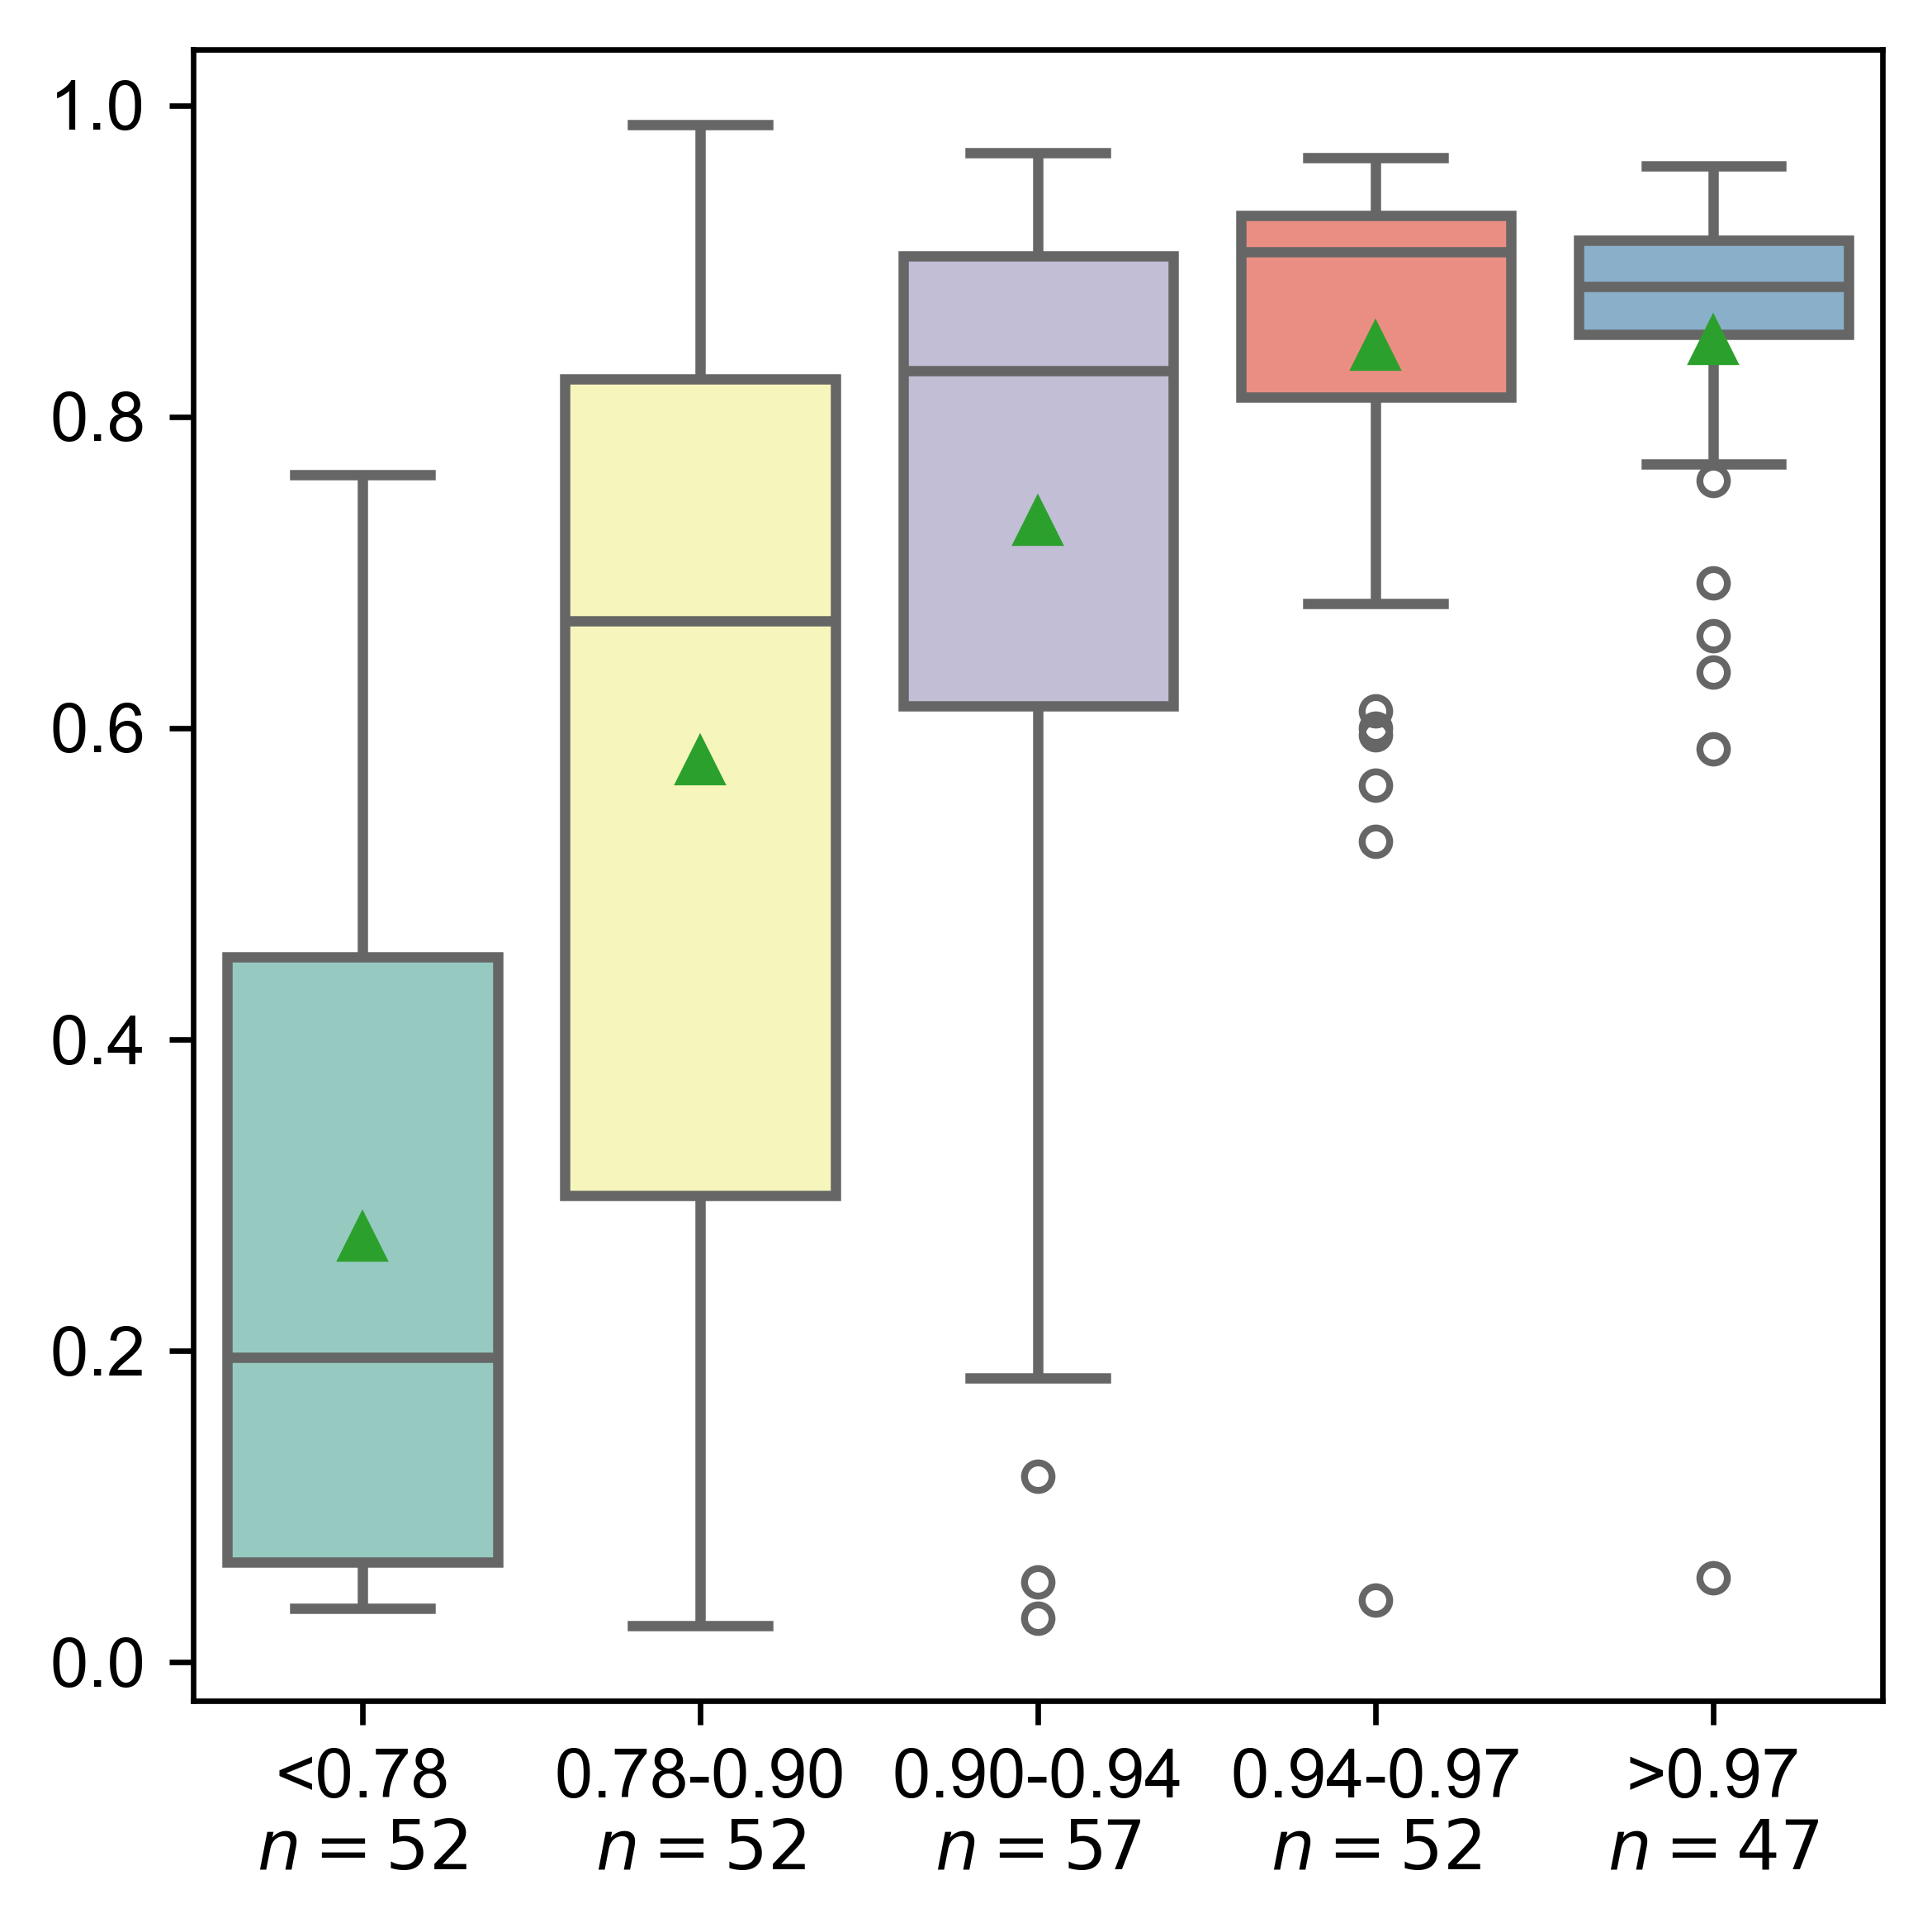

In [11]:
plot_score(
    df_sample, "af3", show_y_ticks=True
)

/tmp/ipykernel_2520952/1966152887.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels_with_counts)
/tmp/ipykernel_2520952/1966152887.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


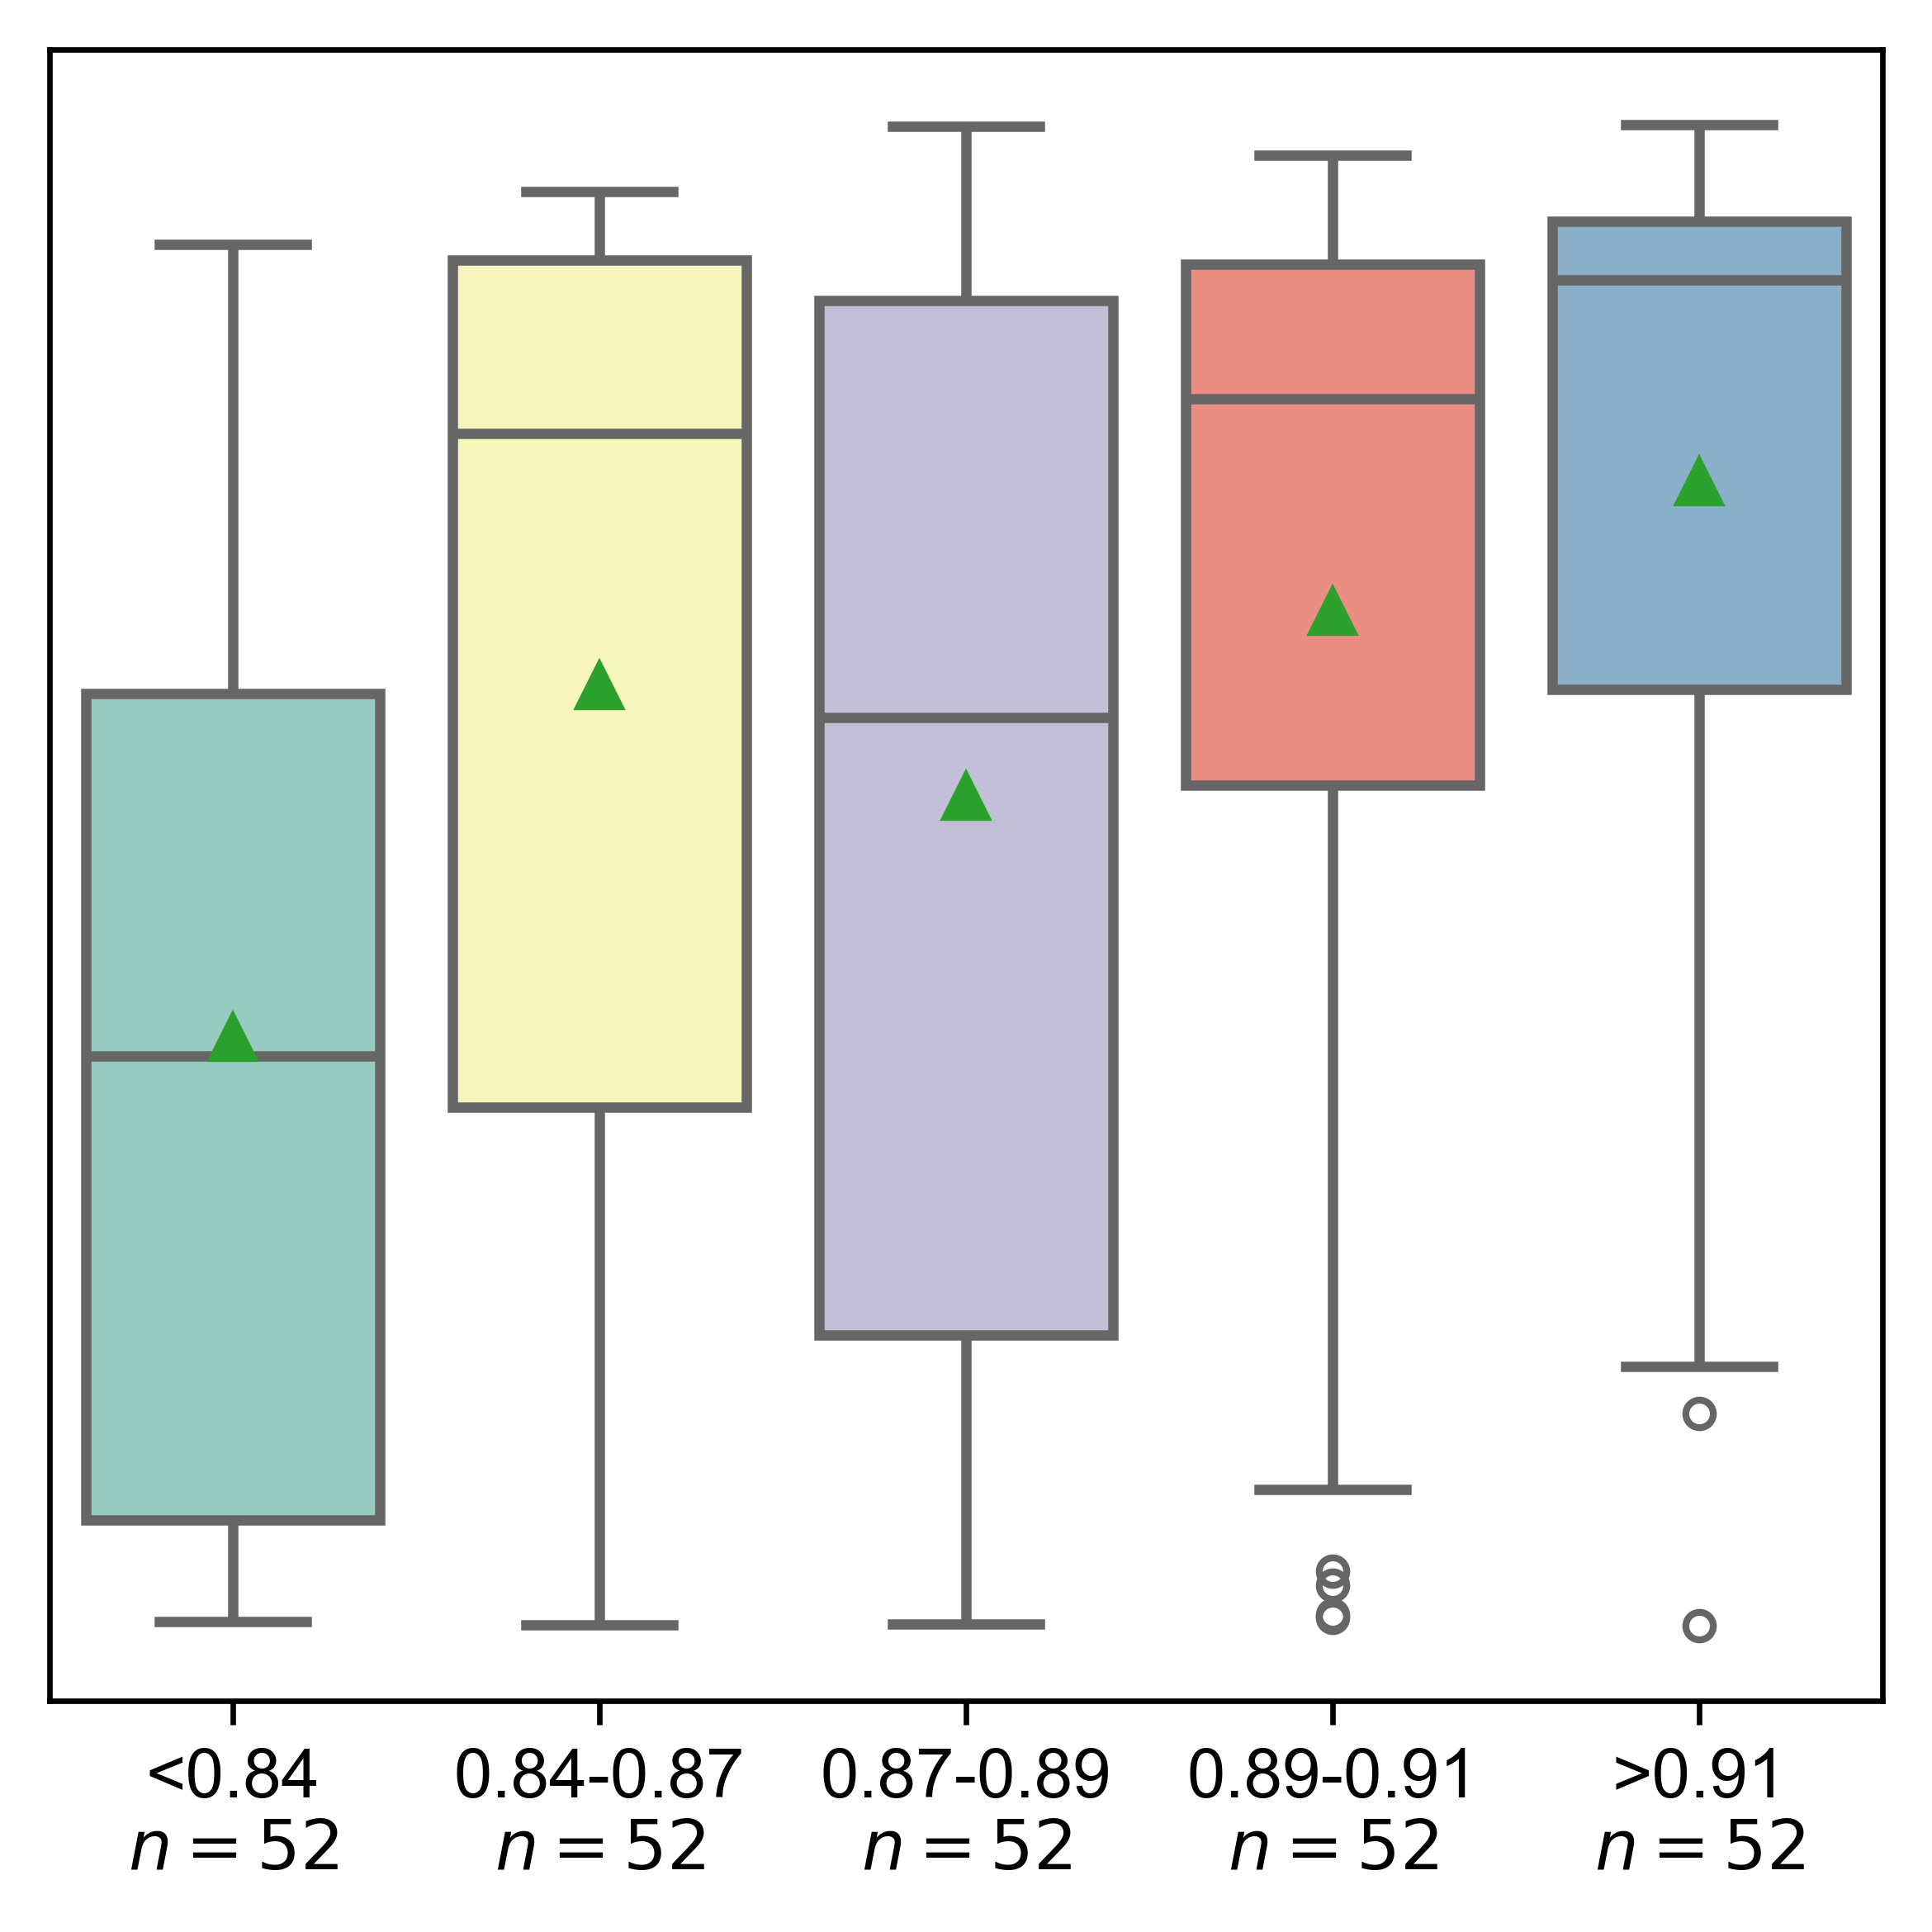

In [12]:
plot_score(
    df_sample, "helix"
)

/tmp/ipykernel_2520952/1966152887.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels_with_counts)
/tmp/ipykernel_2520952/1966152887.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


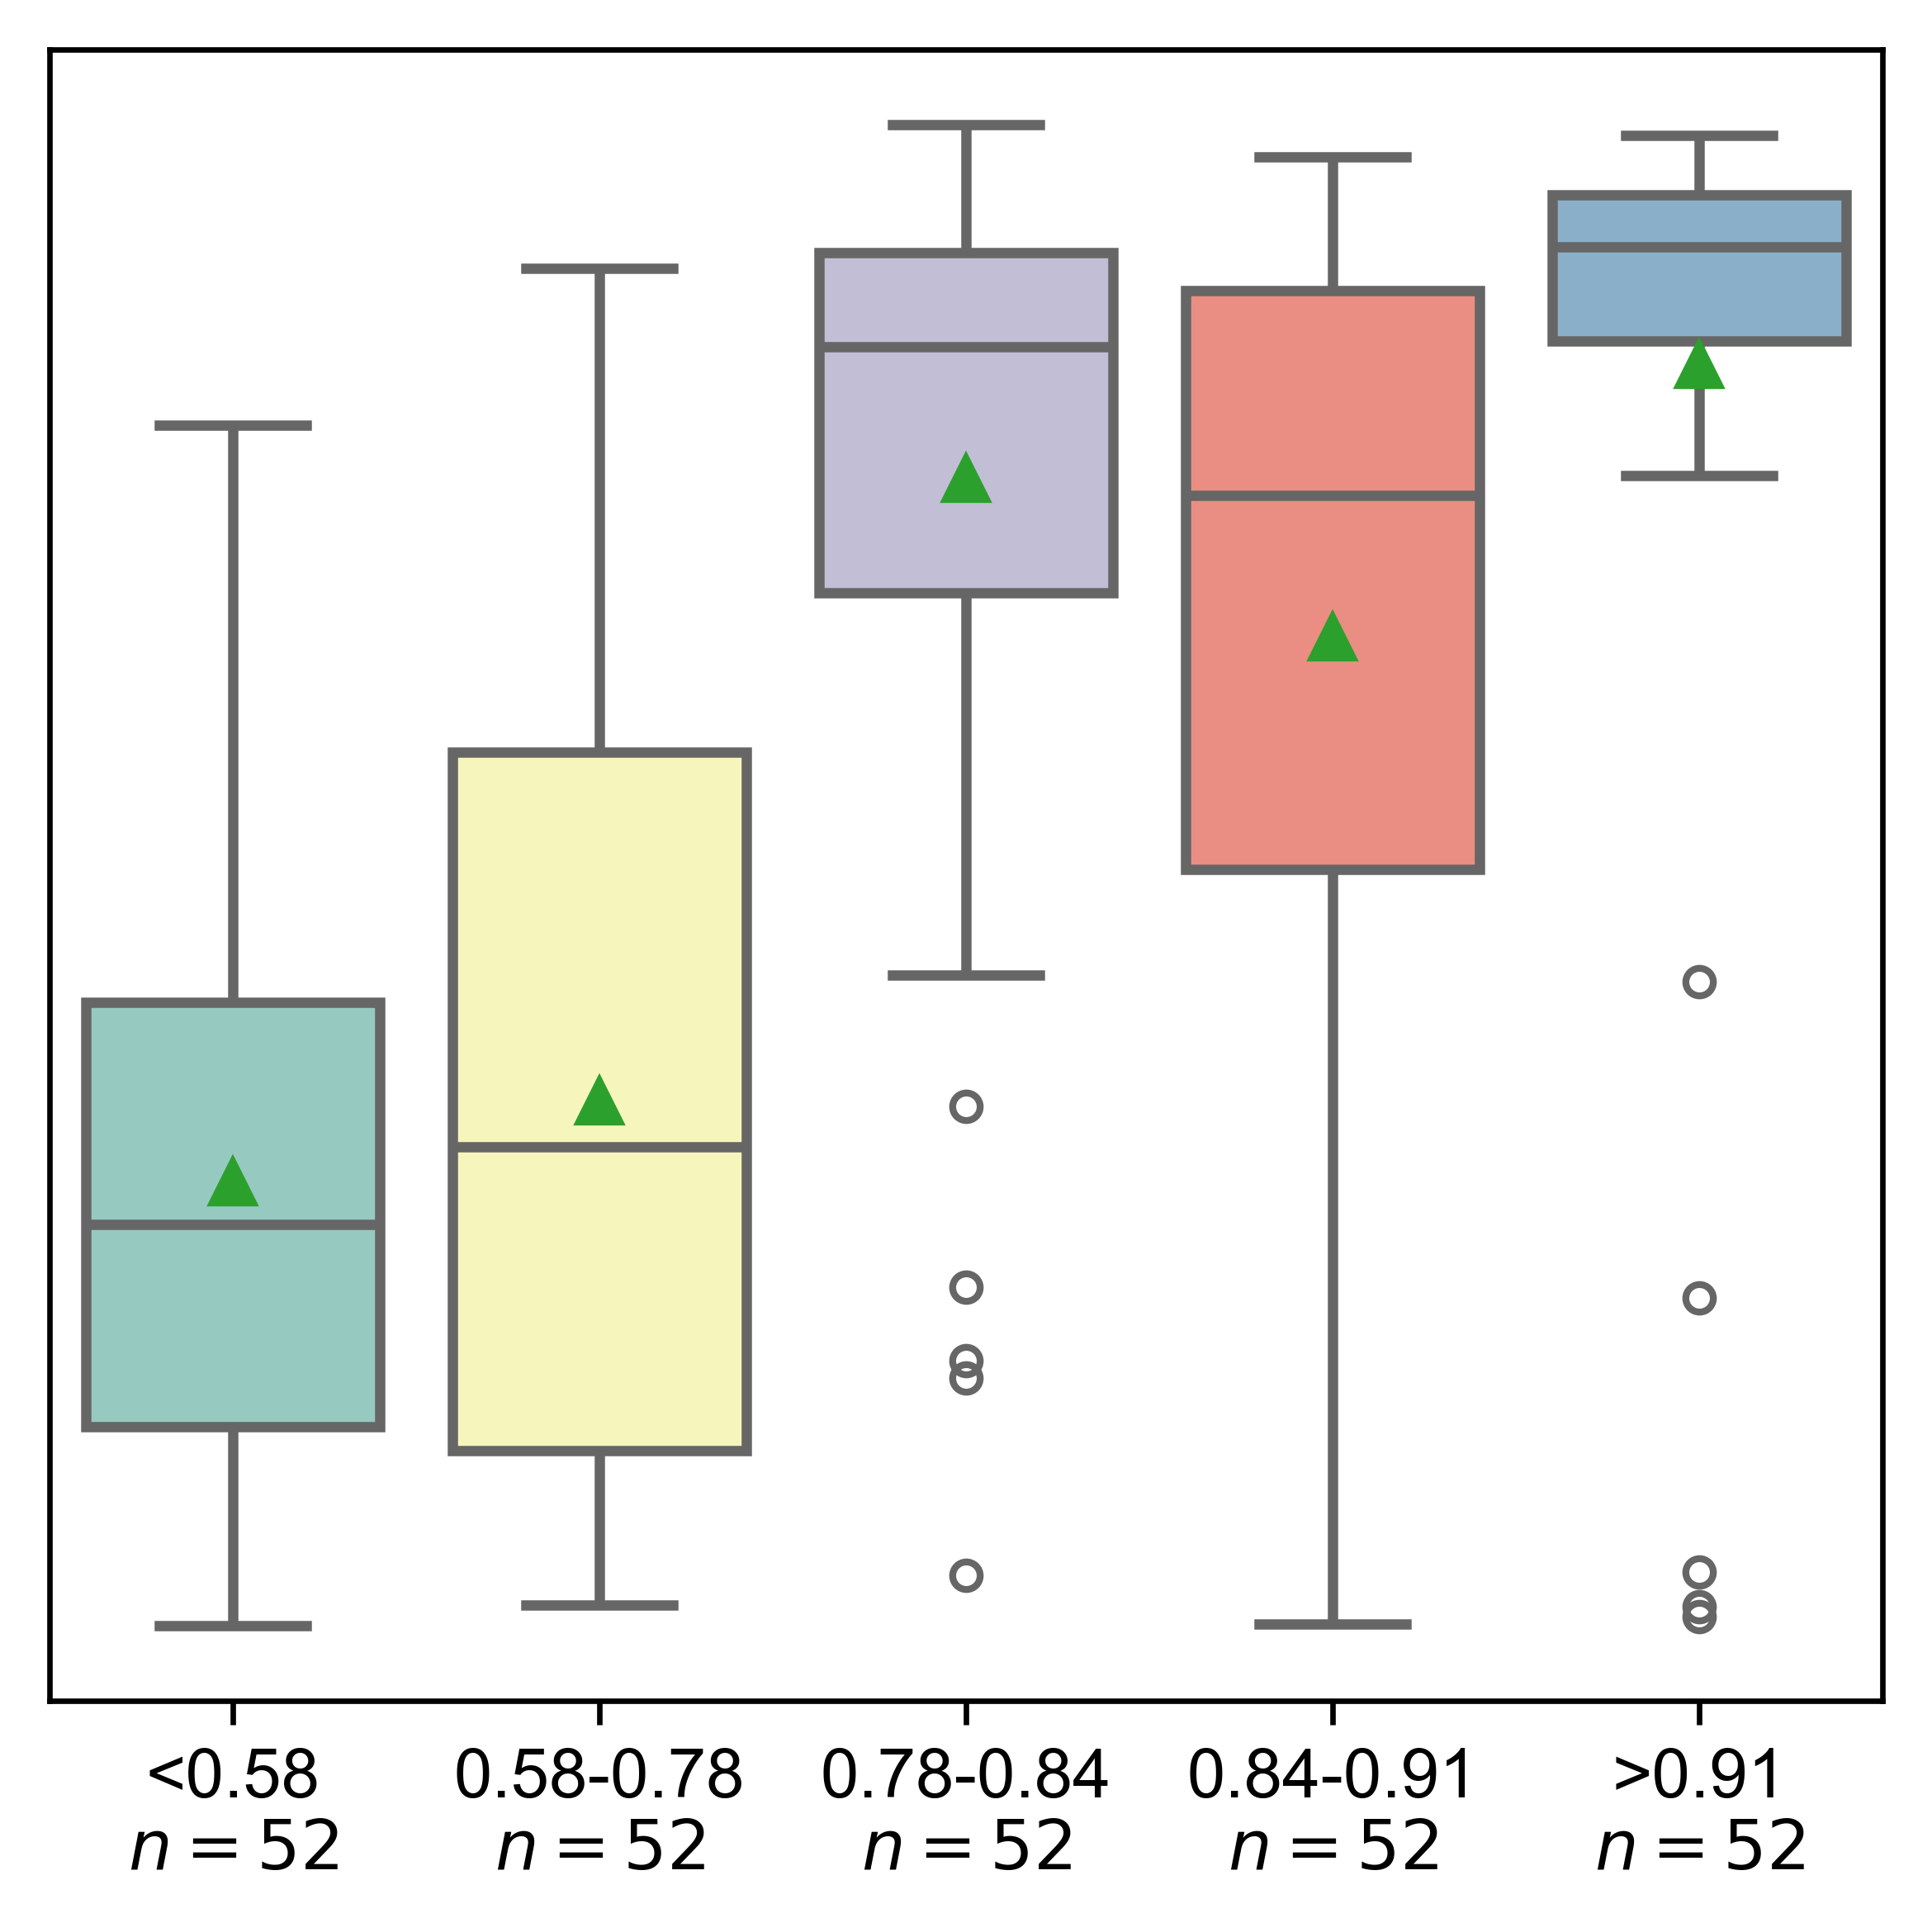

In [13]:
plot_score(
    df_sample, "chai"
)

/tmp/ipykernel_2520952/1966152887.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels_with_counts)
/tmp/ipykernel_2520952/1966152887.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


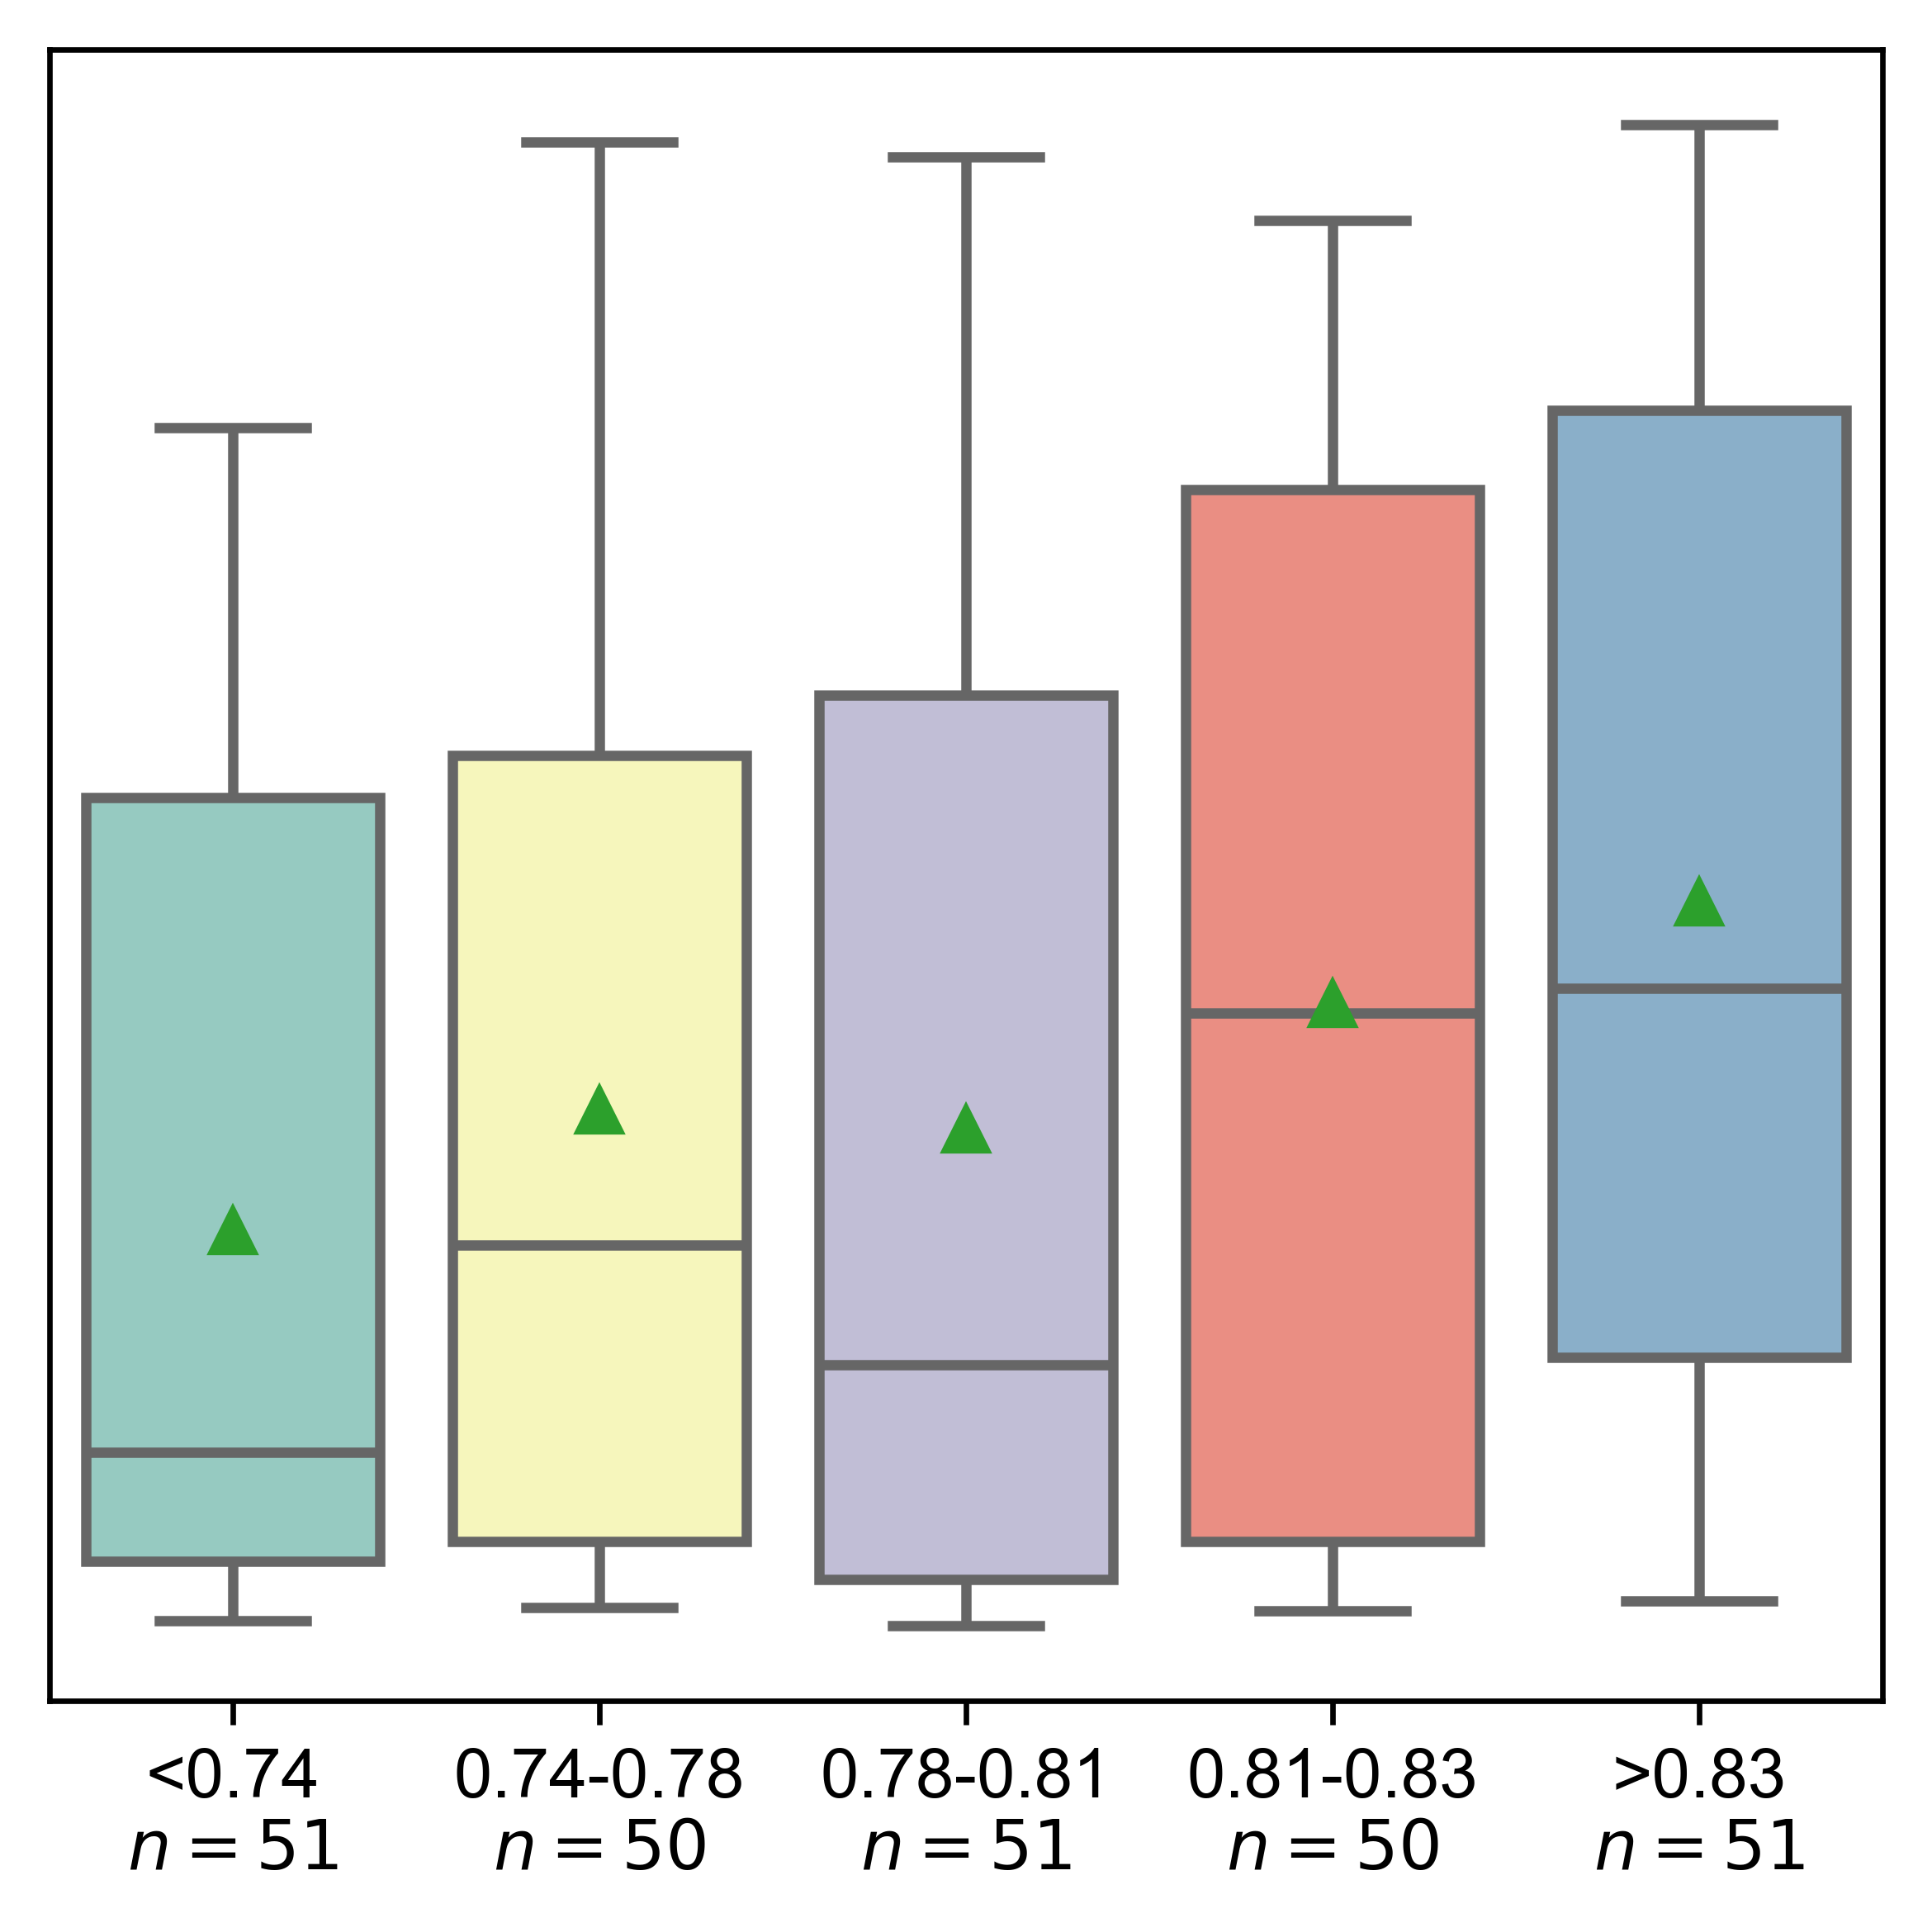

In [14]:
plot_score(
    df_sample, "rfaa"
)

/tmp/ipykernel_2520952/1966152887.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(bin_labels_with_counts)
/tmp/ipykernel_2520952/1966152887.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


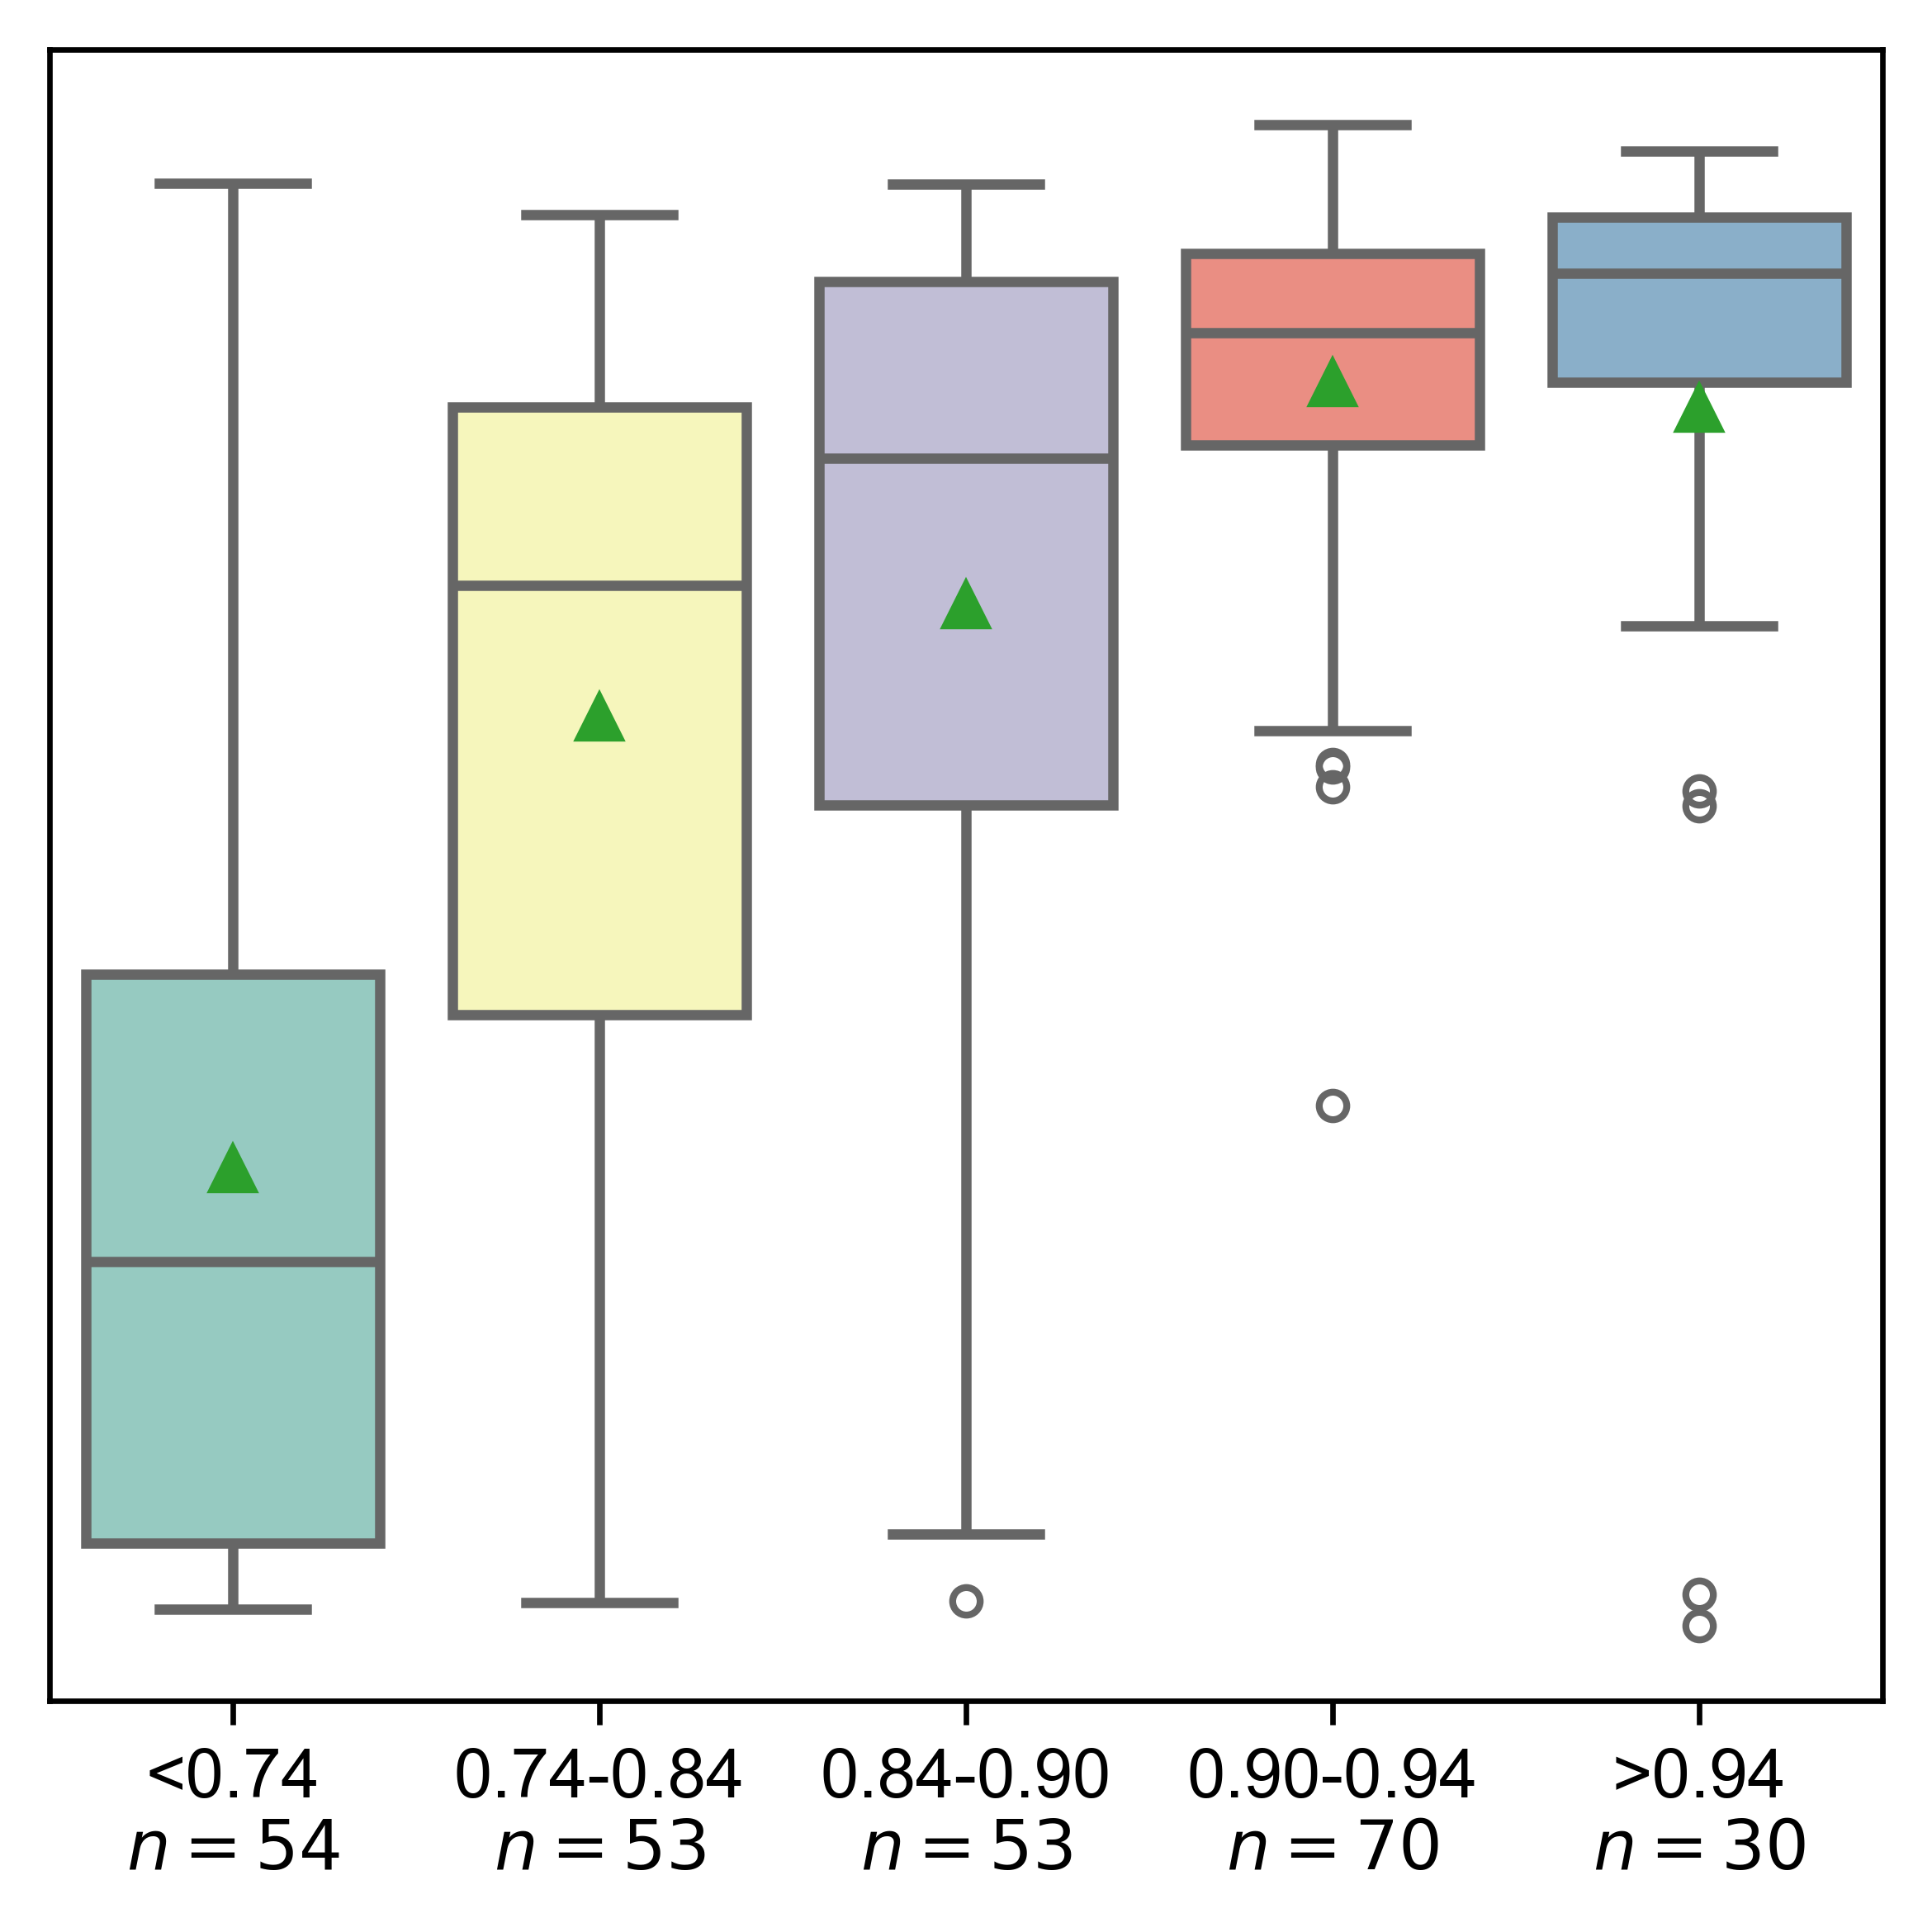

In [15]:
plot_score(
    df_sample, "afm"
)

In [16]:
# 计算 binding_energy
def search_energy(model_name: str, job_name: str, seed: str, rank: int):
    global df_energy
    job_id = f"{job_name}_{model_name}_seed_{seed}_rank_{rank}"
    try:
        return df_energy.loc[df_energy["job_id"] == job_id, "dG_cross"].values[0]
    except IndexError:
        print(f"Error: job_id {job_id} not found in df_energy.")
        return None
    
def get_df_energy(model_list: list[str], result_dir: Path) -> pd.DataFrame:
    df_list = []
    for model_name in model_list:
        df_energy = pd.read_csv(result_dir / f"deltaG_{model_name}.csv")
        df_list.append(df_energy)
    return pd.concat(df_list)

In [17]:
df_energy = get_df_energy(model_list, results_dir)

tqdm.pandas(desc="Fill Binding Energy")
df_sample["binding_energy"] = df_sample.progress_apply(
    lambda row: search_energy(row["model_name"], row["job_name"], row["seed"], row["rank"]), axis=1
)


Fill Binding Energy: 100%|██████████| 32325/32325 [00:53<00:00, 600.18it/s]


In [18]:
def rerank_score(
    df: pd.DataFrame, score_col: str | None = None, ascending: bool = False
) -> pd.DataFrame:
    df = df.copy()
    if score_col is None:
        score_col = "score"

    if score_col == "score":
        local_col_name = "local_rank"
        global_col_name = "global_rank"
    else:
        local_col_name = f"local_rank_{score_col}"
        global_col_name = f"global_rank_{score_col}"

    df[local_col_name] = (
        df.groupby(["job_name", "model_name", "seed"])[score_col]
        .rank(
            method="first", ascending=ascending
        )  # Use 'first' to ensure ties are broken deterministically
        .astype(int)  # Convert to integers for cleaner output
    )

    # Global rank: Rank within each (job_name, model_name) group
    df[global_col_name] = (
        df.groupby(["job_name", "model_name"])[score_col]
        .rank(
            method="first", ascending=ascending
        )  # Use 'first' for deterministic tie-breaking
        .astype(int)
    )

    return df


df_sample = rerank_score(df_sample, "binding_energy", ascending=True)
df_sample = rerank_score(df_sample, "score", ascending=False)

In [19]:
TOP_N = [1, 2, 3, 4, 5, 10, 15, 20, 25]


def cal_top_n_success(df: pd.DataFrame, rank_col: str):
    success = defaultdict(tuple)
    # Loop through different top-N values
    n_total_jobs = len(df["job_name"].unique())

    for top_n in TOP_N:
        top_n_results = []
        n_success = 0
        n_failed = 0
        n_only_one = 0
        n_only_two = 0

        for job_name, job_group in df[df["success"] == True].groupby("job_name"):
            top_n_group = job_group[job_group[rank_col].astype(int) <= top_n]

            if not top_n_group.empty:
                if len(top_n_group) == 1:
                    n_only_one += 1
                elif len(top_n_group) == 2:
                    n_only_two += 1
                n_success += 1
                success_status = "success"
            else:
                n_failed += 1
                success_status = "failed"

            # Append the results for this job_name to the TOP-N list
            top_n_results.append(
                {"job_name": job_name, "status": success_status},
            )

        success_rate = n_success / n_total_jobs if n_success + n_failed > 0 else 0
        success[top_n] = (top_n_results, success_rate)
        # print(f"top_n: {top_n}, n_success: {n_success}, n_failed: {n_failed}")
        # print(f"n_only_one: {n_only_one}, n_only_two: {n_only_two}")

    return success


def plot_success_all_models(
    df: pd.DataFrame, model_list: list[str], score_col: str | None = None
):
    _plot_data: dict[str, list[float]] = {}
    for model_name in model_list:
        df_model = df[df["model_name"] == model_name]
        df_model = rerank_score(df_model)
        if score_col is not None:
            confidence = cal_top_n_success(df_model, f"global_rank_{score_col}")
        else:
            confidence = cal_top_n_success(df_model, "global_rank")
        _plot_data[model_name] = [confidence[n][1] for n in TOP_N]  # 使用 success_rate
    _plot_data["Top-N"] = [f"Top-{n}" for n in TOP_N]
    plot_data: pd.DataFrame = pd.DataFrame(_plot_data)
    plot_data_long = plot_data.melt(
        id_vars="Top-N", var_name="Metrics", value_name="Value"
    )
    plt.figure(dpi=150)  # 如果没特别需要，使用dpi=150
    line_plot = sns.lineplot(
        data=plot_data_long,
        x="Top-N",
        y="Value",
        hue="Metrics",
        palette="Set2",
        marker="o",
        linewidth=2.5,
    )
    line_plot.set_title(f"Success Rate and Top-n for All Models")
    line_plot.set_xlabel("Top-n")
    line_plot.set_ylabel("Success Rate (%)")

    plt.legend(title="Metrics", loc="best")

    plt.tight_layout()
    plt.show()

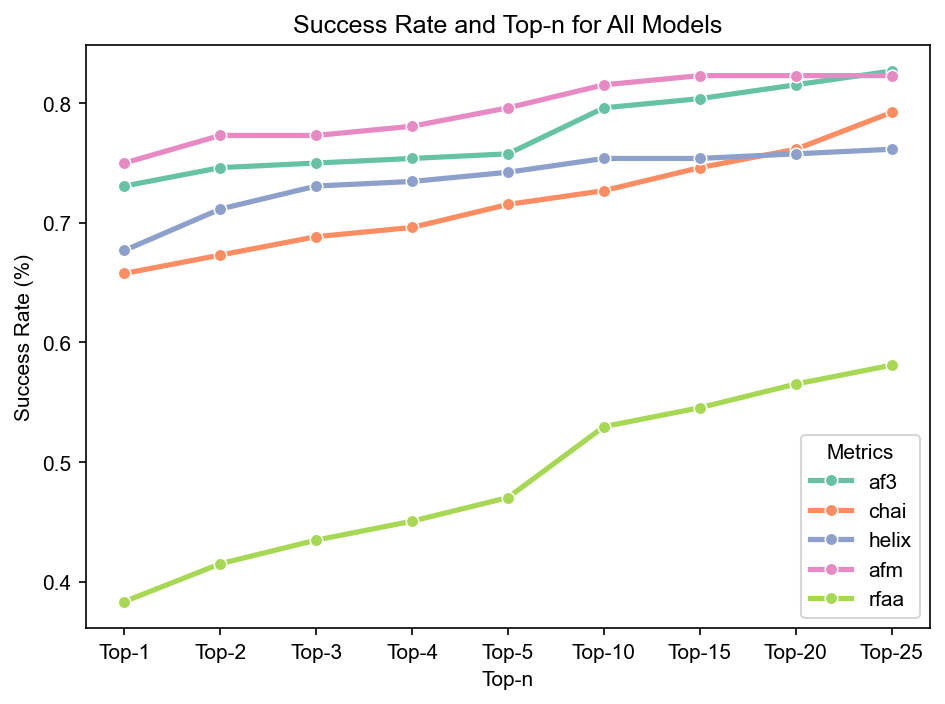

In [20]:
df_sample["success"] = (df_sample["fnat"] > 0.2) & (df_sample["LRMSD"] < 7)
plot_success_all_models(df_sample, model_list)

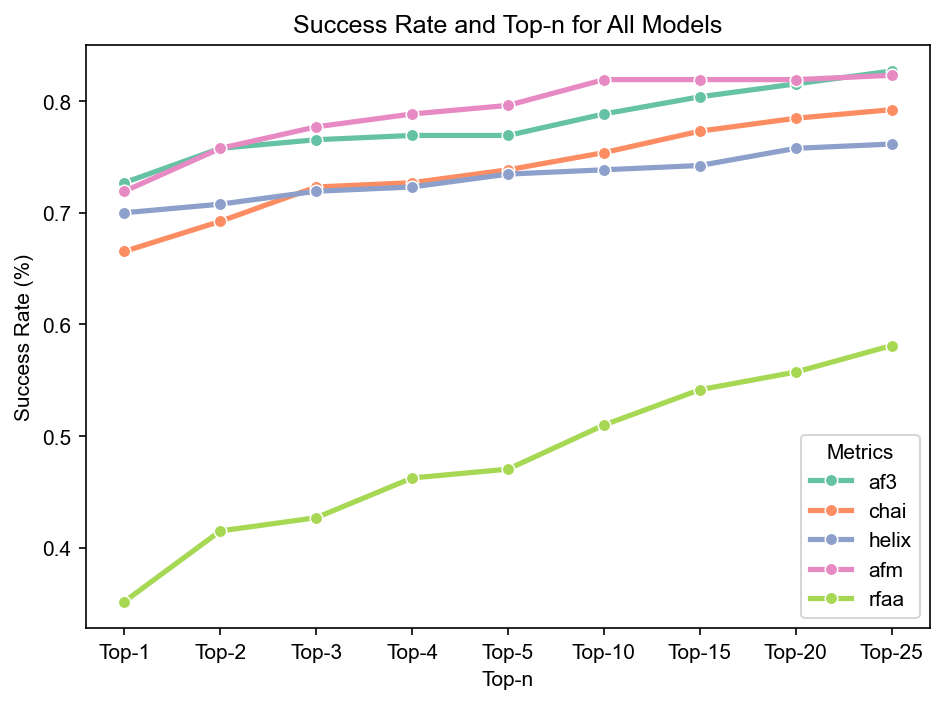

In [21]:
df_sample["success"] = (df_sample["fnat"] > 0.2) & (df_sample["LRMSD"] < 7)
plot_success_all_models(df_sample, model_list, score_col="binding_energy")

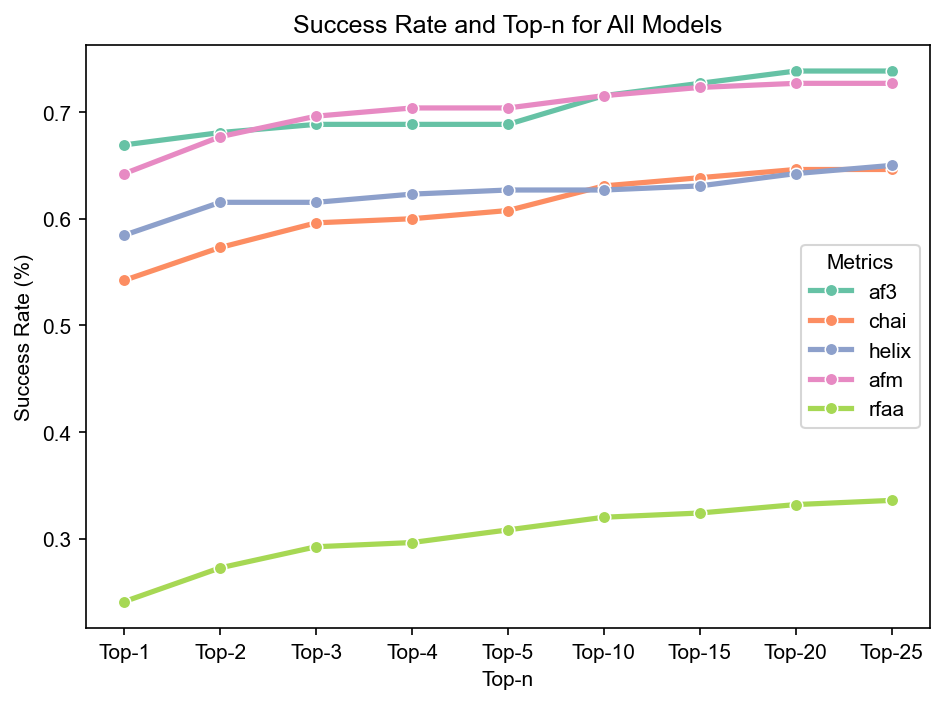

In [22]:
df_sample["success"] = (df_sample["fnat"] > 0.5) & (df_sample["LRMSD"] < 5)
plot_success_all_models(df_sample, model_list, score_col="binding_energy")

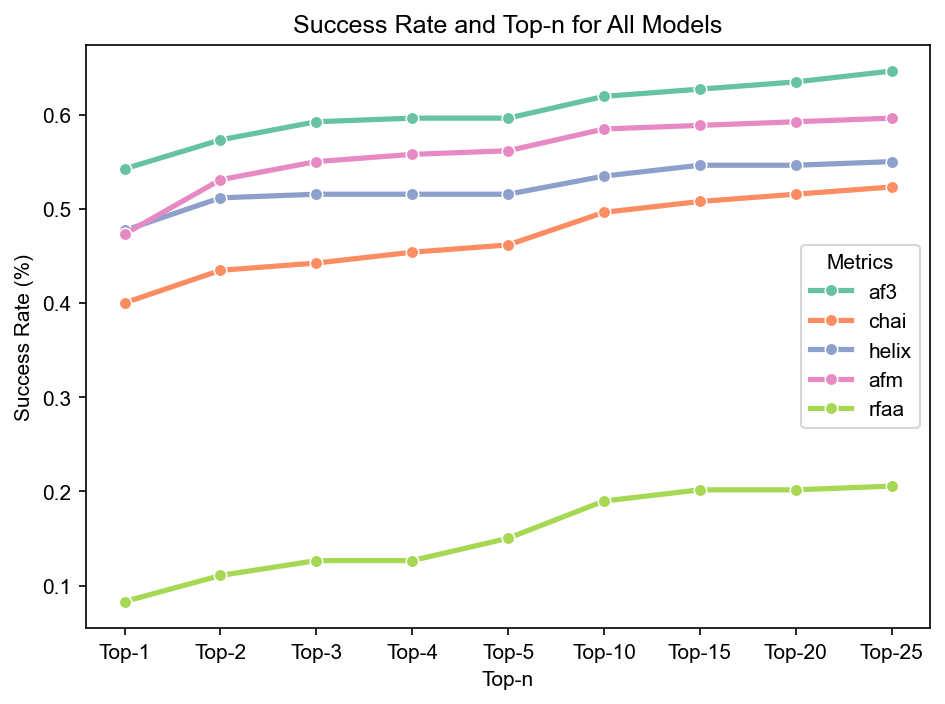

In [23]:
df_sample["success"] = (df_sample["fnat"] > 0.7) & (df_sample["LRMSD"] < 3)
plot_success_all_models(df_sample, model_list)

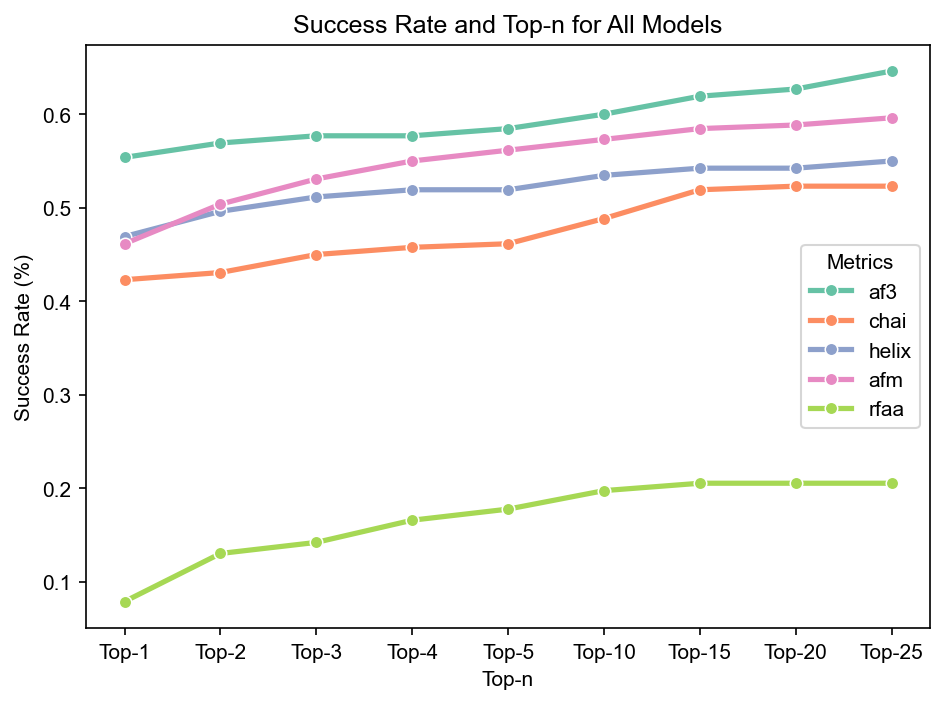

In [24]:
df_sample["success"] = (df_sample["fnat"] > 0.7) & (df_sample["LRMSD"] < 3)
plot_success_all_models(df_sample, model_list, score_col="binding_energy")

In [87]:
def cal_top1_success(df: pd.DataFrame, rank_col: str = None, mode: str = "actual") -> float:
    """
    计算某一排序方式下 Top-1 成功率
    mode: "actual"（Top-1 success），"random"（随机期望 success）
    """
    if rank_col not in df.columns and mode == "actual":
        raise ValueError(f"Column '{rank_col}' not in dataframe")

    job_groups = df.groupby("job_name")
    n_total_jobs = len(job_groups)
    total_success = 0

    for job_name, group in job_groups:
        if mode == "actual":
            sub = group[group["success"] == True]
            top1 = sub[sub[rank_col].astype(float) == 1]
            if not top1.empty:
                total_success += 1
        elif mode == "random":
            num_total = len(group)
            num_success = group["success"].sum()
            prob = num_success / num_total if num_total > 0 else 0
            total_success += prob
        elif mode == "uplimit":
            sub = group[group["success"] == True]
            if not sub.empty:
                total_success += 1
        else:
            raise ValueError("Invalid mode. Use 'actual' or 'random'.")

    return total_success / n_total_jobs if n_total_jobs > 0 else 0


def plot_top1_success_comparison(
    df: pd.DataFrame, model_list: list[str], show_legend=False, y_ticks=False
):
    model_names = []
    expected_rates = []
    score_rates = []
    energy_rates = []
    uplimit_rates = []

    for model_name in model_list:
        df_model = df[df["model_name"] == model_name].copy()
        expected_success = cal_top1_success(df_model, rank_col="rank", mode="random")
        score_success = cal_top1_success(df_model, "global_rank")
        energy_success = cal_top1_success(df_model, "global_rank_binding_energy")
        uplimit_success = cal_top1_success(df_model, mode="uplimit")
        model_names.append(model_name)
        expected_rates.append(expected_success)
        score_rates.append(score_success)
        energy_rates.append(energy_success)
        uplimit_rates.append(uplimit_success)

    x = range(len(model_names))
    width = 0.23

    set2_colors = sns.color_palette("Set3")
    score_color = set2_colors[0]
    energy_color = set2_colors[1]
    uplimit_color = set2_colors[5]

    plt.figure(figsize=(5.5, 3), dpi=600)
    bars_expected = plt.bar(
        [i - 1.5 * width for i in x],
        expected_rates,
        width=width,
        label="Expected",
        color="lightgray",
        edgecolor="black",
    )
    bars_score = plt.bar(
        [i - 0.5 * width for i in x],
        score_rates,
        width=width,
        label="Score",
        color=score_color,
        edgecolor="black",
    )
    bars_energy = plt.bar(
        [i + 0.5 * width for i in x],
        energy_rates,
        width=width,
        label="Binding Energy",
        color=energy_color,
        edgecolor="black",
    )
    bars_uplimit = plt.bar(
        [i + 1.5 * width for i in x],
        uplimit_rates,
        width=width,
        label="Uplimit",
        color=uplimit_color,
        edgecolor="black",
    )

    # 添加数值标签
    def annotate_bars(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=6,
                fontweight="bold",
            )

    annotate_bars(bars_expected)
    annotate_bars(bars_score)
    annotate_bars(bars_energy)
    annotate_bars(bars_uplimit)

    # 自定义 label 映射
    custom_labels = {
        "af3": "AF3",
        "chai": "Chai-1",
        "helix": "HF3",
        "afm": "AFM",
        "rfaa": "RFAA",
    }
    xtick_labels = [custom_labels.get(name, name) for name in model_names]
    plt.xticks(x, xtick_labels, ha="center")
    plt.ylim(0, 1)

    if show_legend:
        plt.legend()
    if not y_ticks:
        plt.yticks([])

In [88]:
def get_capri(fnat: float, lrmsd: float, irmsd: float) -> float:
    if (fnat >= 0.8 and fnat <= 1) and (lrmsd < 1 or irmsd < 0.5):
        return 3
    elif (fnat >= 0.5 and fnat <= 0.8) and (lrmsd < 2 or irmsd < 1) or (fnat >= 0.8 and fnat <= 1):
        return 2
    elif (fnat >= 0.2 and fnat <= 0.5) and (lrmsd < 4 or irmsd < 2) or (fnat >= 0.5 and fnat <= 1) and (lrmsd > 2 and irmsd > 1):
        return 1
    else:
        return 0

In [89]:
def get_success(df, mode="high"):
    _df = df.copy()
    if mode == "high":
        _df["success"] = _df["capri"] == 3
    elif mode == "medium":
        _df["success"] = _df["capri"] >= 2
    elif mode == "acceptable":
        _df["success"] = _df["capri"] >= 1
    elif mode == "inacceptable":
        _df["success"] = _df["capri"] == 0
    else:
        raise ValueError(f"Invalid mode: {mode}")
    return _df["success"]

In [90]:
df_sample["capri"] = df_sample.apply(lambda x: get_capri(x["fnat"], x["LRMSD"], x["iRMSD"]), axis=1)

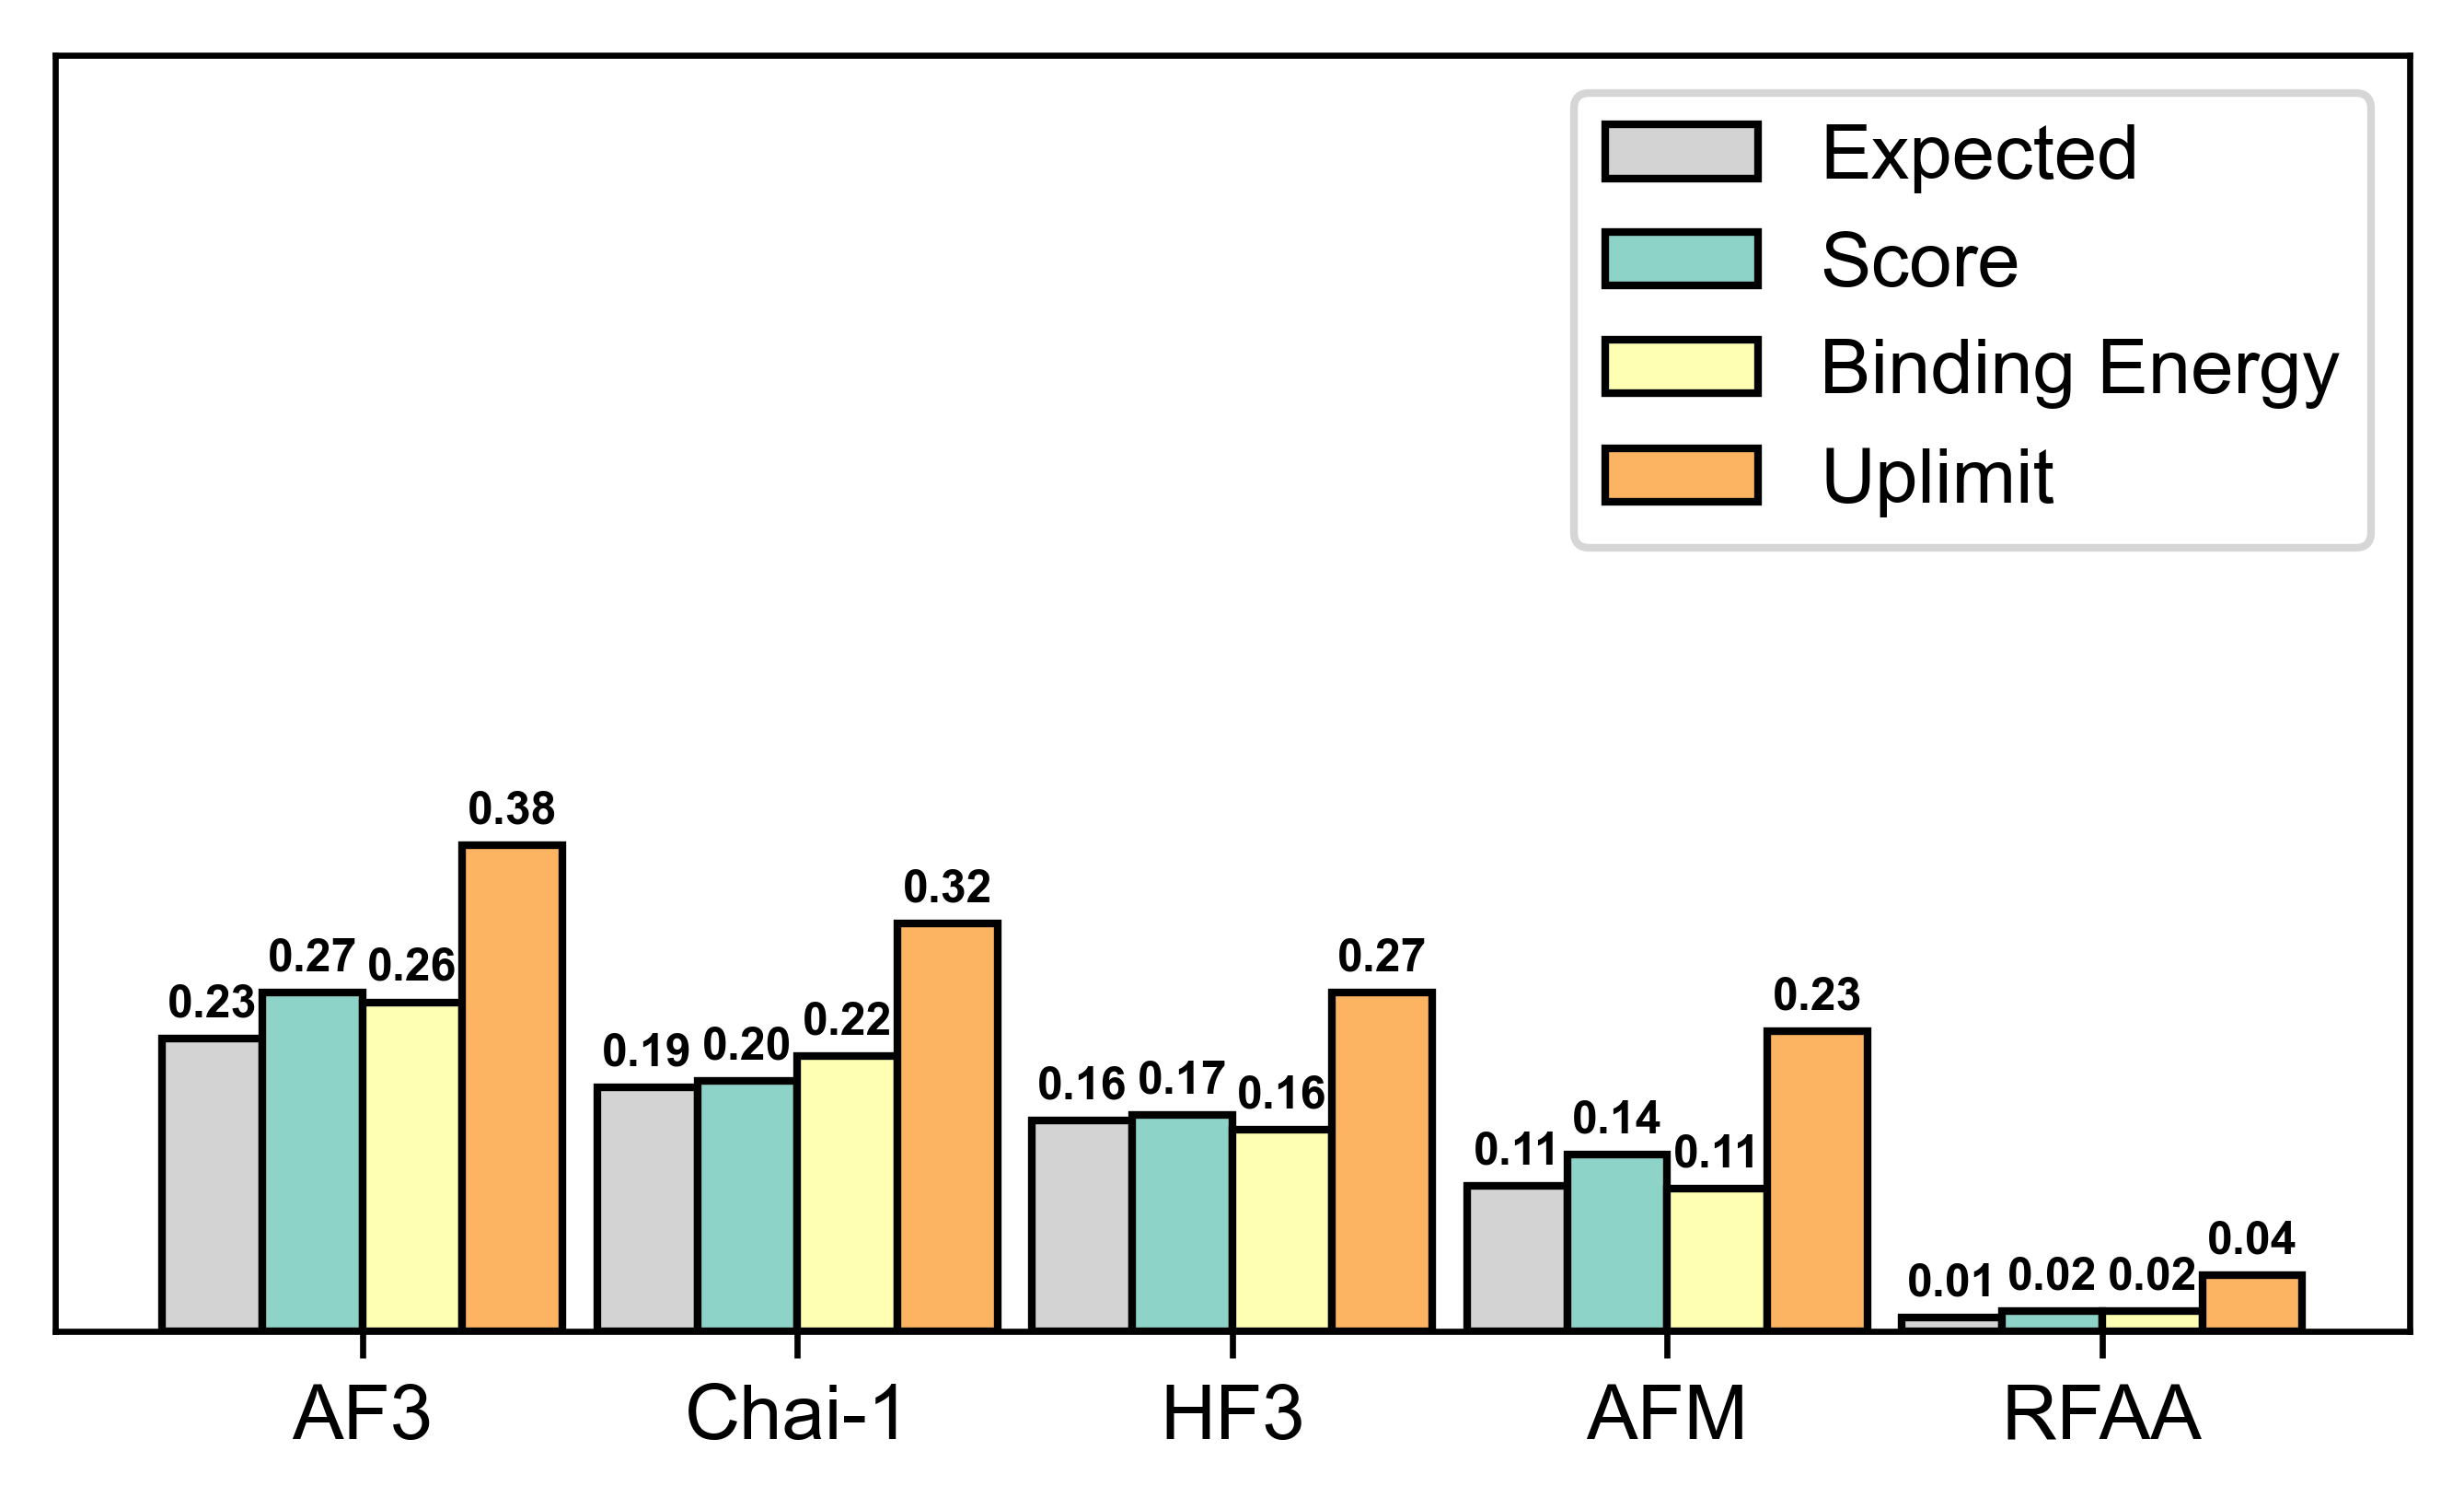

In [91]:
df_sample["success"] = get_success(df_sample, mode="high")

plot_top1_success_comparison(df_sample, model_list, show_legend=True)

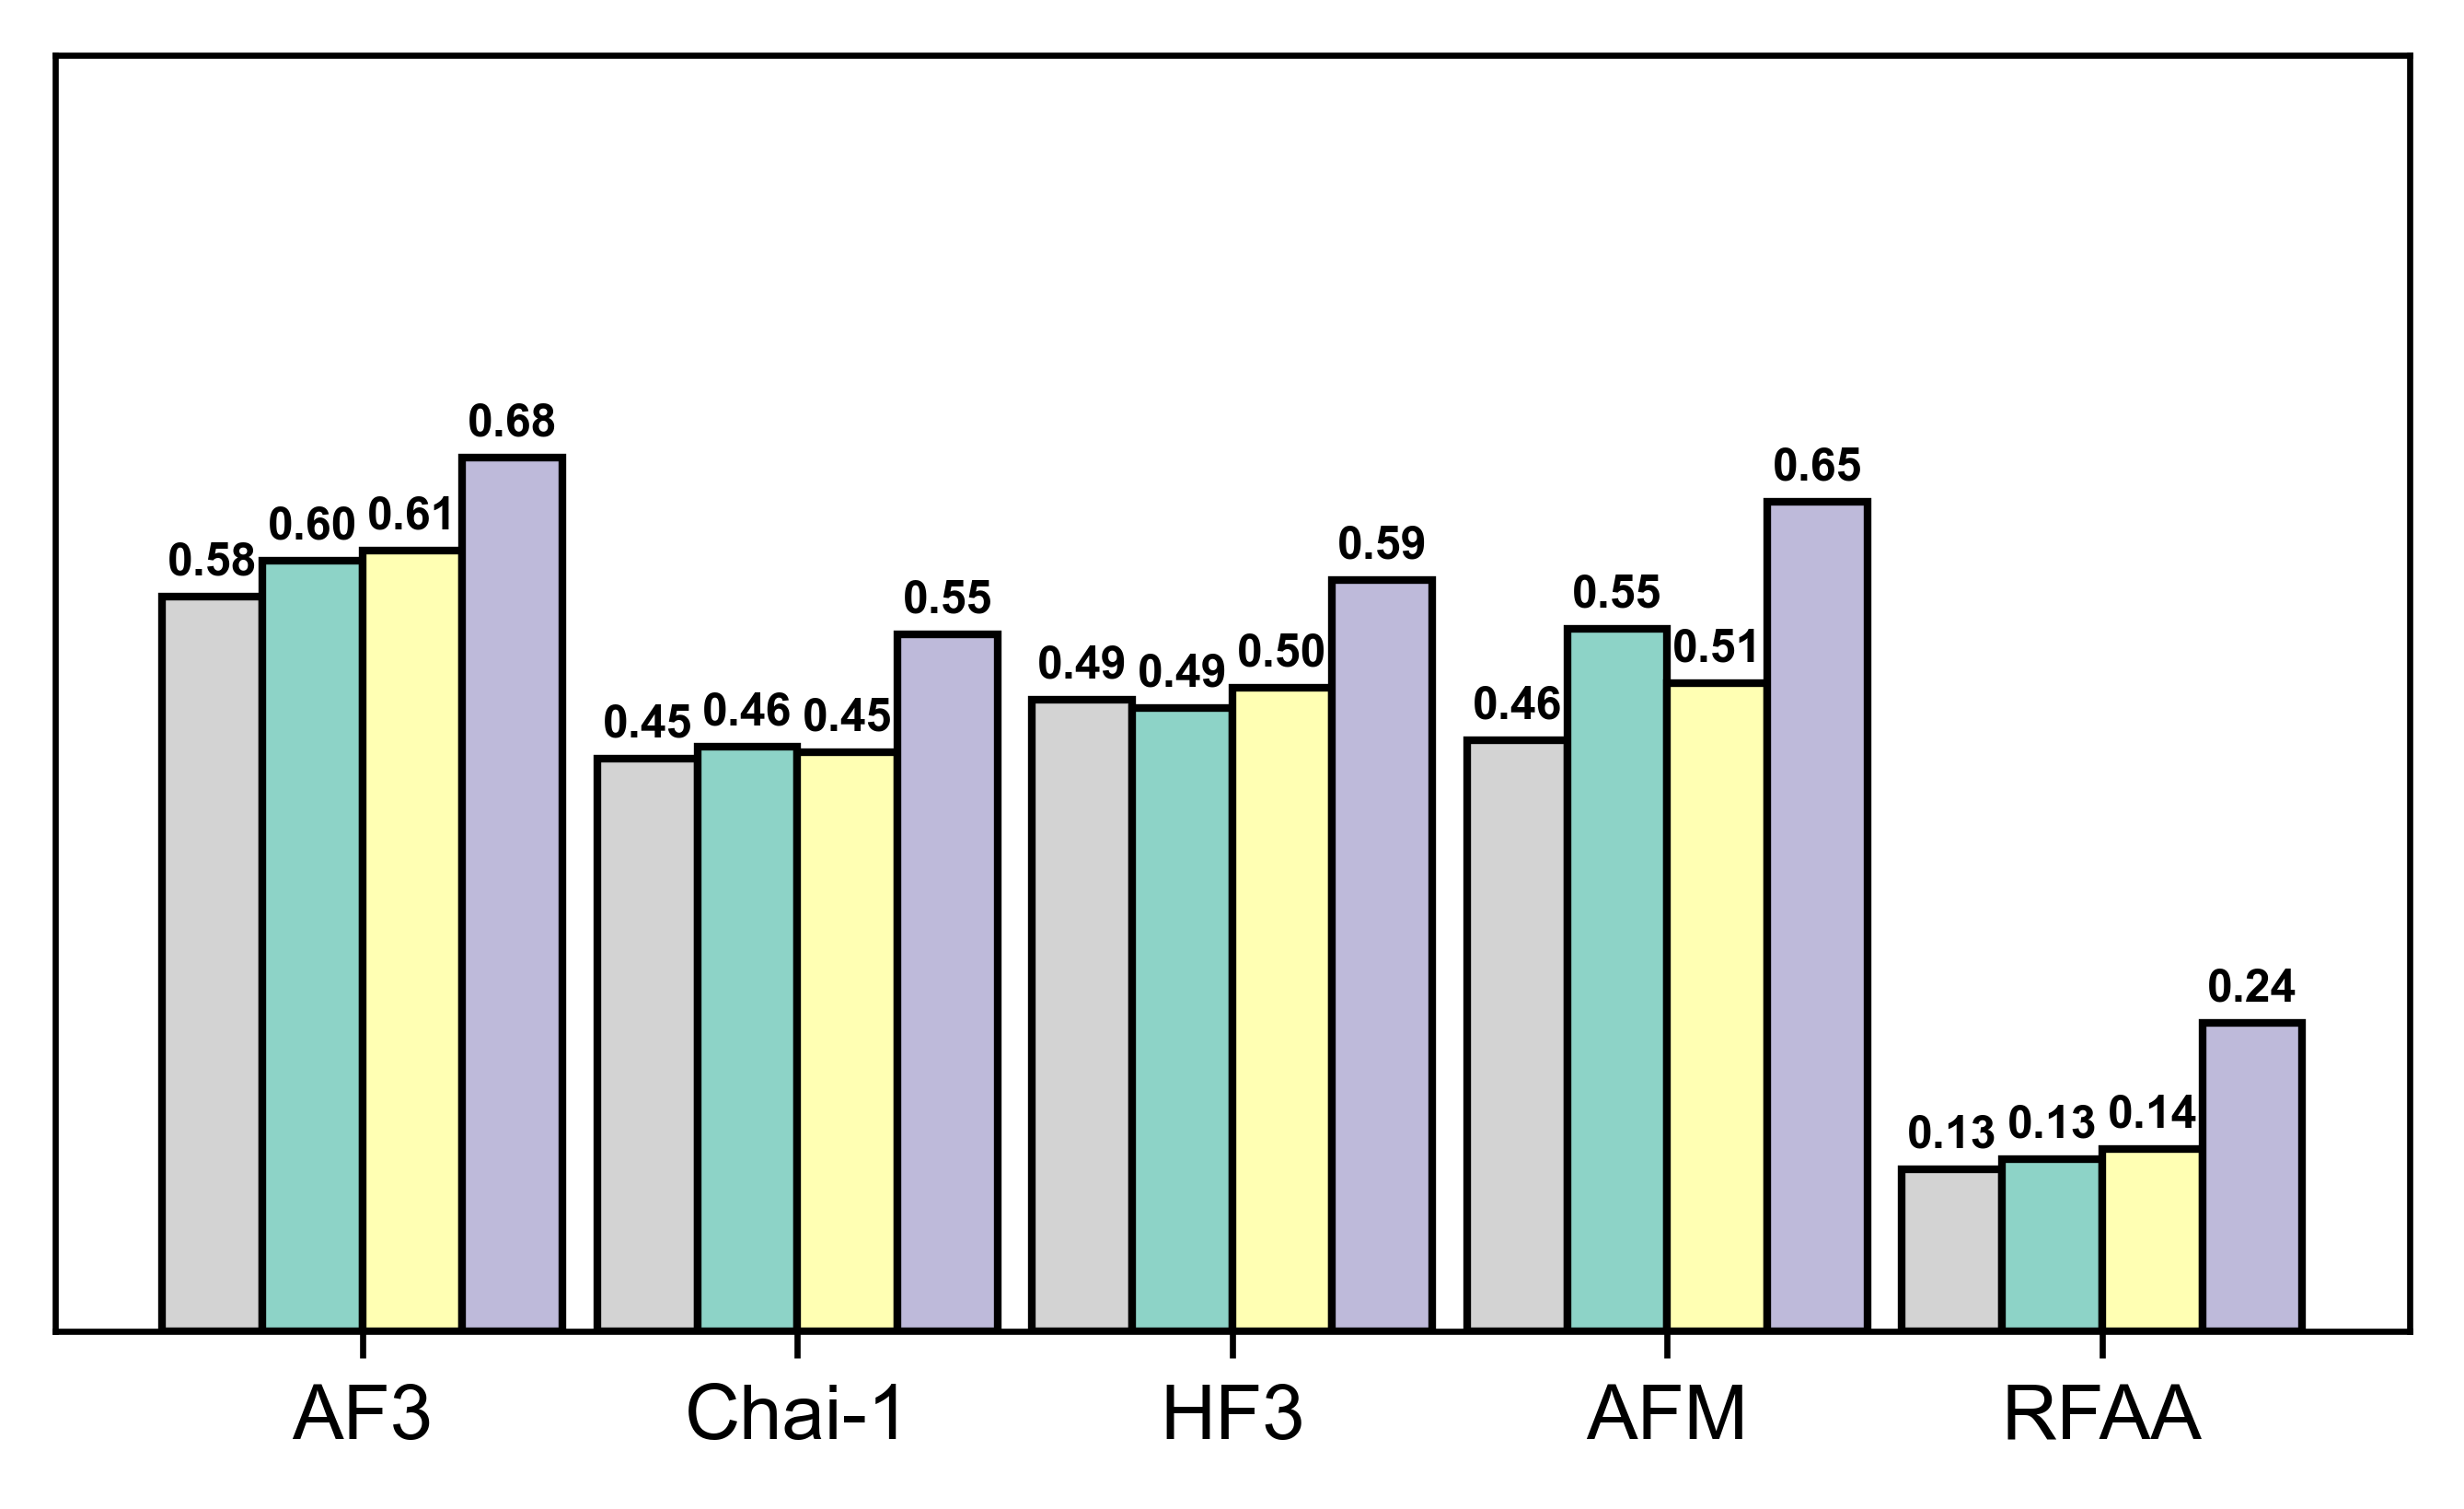

In [85]:
df_sample["success"] = get_success(df_sample, mode="medium")

plot_top1_success_comparison(df_sample, model_list)

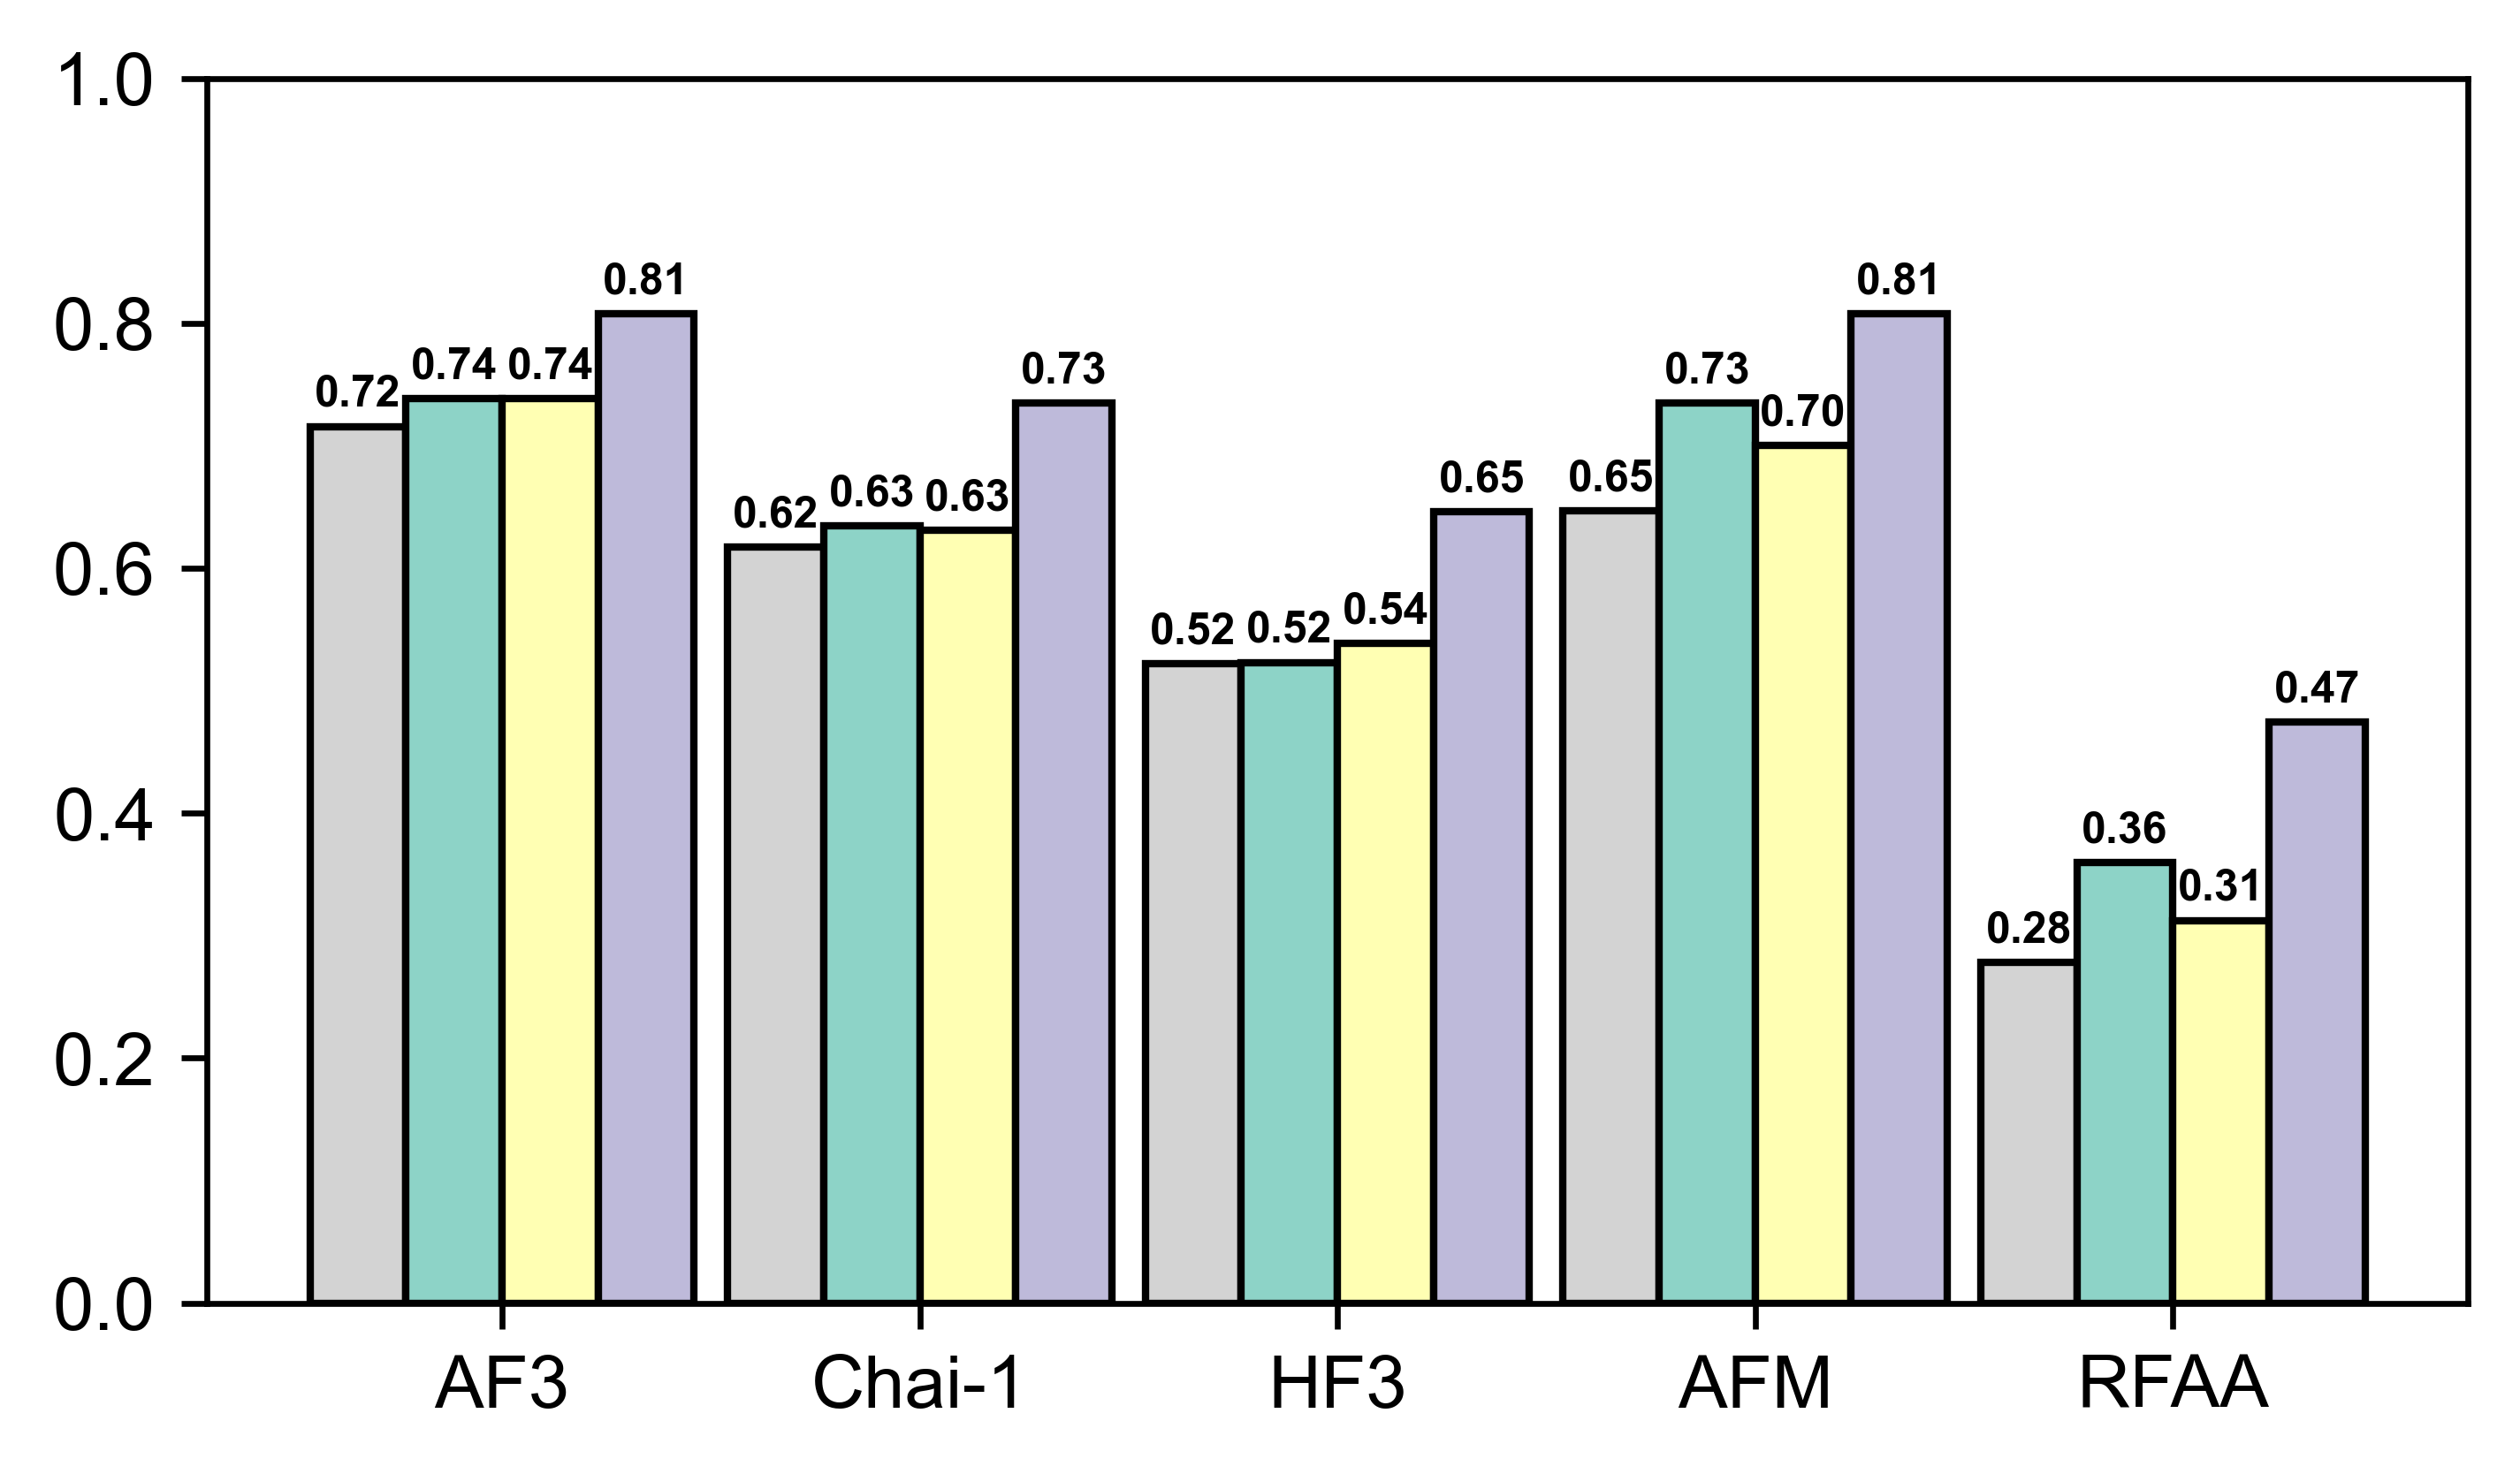

In [86]:
df_sample["success"] = get_success(df_sample, mode="acceptable")

plot_top1_success_comparison(df_sample, model_list, y_ticks=True)